<h1 style="text-align: center;"> Cyber Security Attack Type Detection </h1>

In [140]:
!pip install catboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import ipaddress
import re
import sqlite3 as sql
import time
import pickle


#from geopy.geocoders import Nominatim    # Unused
#from geopy.extra.rate_limiter import RateLimiter  #unused

from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix
)

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# **1.Data Loading & Basic Overview**

In [2]:
import os

if os.path.exists('cybersecurity_attacks.csv'):       #If the file is open localy with a personal IDE
    df = pd.read_csv('cybersecurity_attacks.csv')
else:                                                 #If the file is open on google colab, 'cybersecurity_attacks.csv' MUST BE DOWNLOADED in the "MyDrive" folder
    from google.colab import drive
    drive.mount('/content/drive')
    df = pd.read_csv('/content/drive/MyDrive/cybersecurity_attacks.csv')

Mounted at /content/drive


In [3]:
def column_profile(df, target=None):
    rows = []
    n = len(df)
    for c in df.columns:
        miss = df[c].isna().mean() * 100
        nunique = df[c].nunique(dropna=True)
        dtype = str(df[c].dtype)

        top_vals = df[c].value_counts(dropna=True).head(3)
        top_str = "; ".join([f"{idx}:{val}" for idx, val in top_vals.items()])

        rows.append({
            "col": c,
            "dtype": dtype,
            "missing_%": round(miss, 2),
            "n_unique": int(nunique),
            "top3": top_str
        })

    prof = pd.DataFrame(rows).sort_values(["missing_%","n_unique"], ascending=[False, False])
    return prof

prof = column_profile(df, target="Attack Type")
prof

,col,dtype,missing_%,n_unique,top3
12,Alerts/Warnings,object,50.17,1,Alert Triggered:19933
23,IDS/IPS Alerts,object,50.12,1,Alert Data:19950
10,Malware Indicators,object,50.00,1,IoC Detected:20000
22,Firewall Logs,object,49.90,1,Log Data:20039
21,Proxy Information,object,49.63,20148,39.123.165.122:2; 108.143.243.168:1; 211.195.1...
1,Source IP Address,object,0.00,40000,138.156.5.40:1; 24.150.253.66:1; 188.133.58.141:1
2,Destination IP Address,object,0.00,40000,91.54.135.213:1; 163.192.200.17:1; 25.179.17.77:1
9,Payload Data,object,0.00,40000,Fugiat tenetur natus perferendis. Mollitia bla...
0,Timestamp,object,0.00,39997,2022-06-11 14:28:15:2; 2022-06-06 12:12:43:2; ...
17,User Information,object,0.00,32389,Heer Lad:6; Ishaan Chaudhari:6; Akarsh Tripathi:5


### Dataset Interpretation

Security-related variables such as Alerts/Warnings, IDS/IPS Alerts, Malware Indicators, and Firewall Logs contain approximately 50% missing values and show very low variability, with a single dominant non-null value when present. Proxy Information also exhibits a high proportion of missing values along with high cardinality.

Source and destination IP addresses as well as Payload Data display maximum cardinality, with nearly one unique value per observation. User Information and Device Information similarly show a large number of distinct values and limited repetition.

Numerical variables (Source Port, Destination Port, Packet Length, and Anomaly Scores) have no missing values and present wide distributions, particularly for port numbers and anomaly scores.

Several categorical variables (Protocol, Traffic Type, Packet Type, Attack Signature, Action Taken, Severity Level, Network Segment, and Log Source) have low cardinality and relatively balanced distributions. The target variable (Attack Type) is also evenly distributed across the three classes.

# **2. Exploratory Data Analysis (EDA)**

## 2.1 Timestamp VS Attack type
This variable indicates the exact date and time of each security event and allows the analysis of temporal attack patterns as well as the extraction of relevant time-based features.

In [4]:
# Convert Timestamp to datetime & check for NaT values

df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")

print("NaT in Timestamp:", df["Timestamp"].isna().sum())
print("Timestamp range:",
      df["Timestamp"].min(), "->", df["Timestamp"].max())


NaT in Timestamp: 0
Timestamp range: 2020-01-01 00:43:27 -> 2023-10-11 19:34:23


In [5]:
# Extract datetime features: hour, day of week, month, is_weekend

df["hour"] = df["Timestamp"].dt.hour
df["dayofweek"] = df["Timestamp"].dt.dayofweek   # 0 = lundi
df["month"] = df["Timestamp"].dt.month
df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(int)

df[["Timestamp", "hour", "dayofweek", "month", "is_weekend"]].head(5)


,Timestamp,hour,dayofweek,month,is_weekend
0,2023-05-30 06:33:58,6,1,5,0
1,2020-08-26 07:08:30,7,2,8,0
2,2022-11-13 08:23:25,8,6,11,1
3,2023-07-02 10:38:46,10,6,7,1
4,2023-07-16 13:11:07,13,6,7,1


In [6]:
# distribution of attack types across days of the week

pd.crosstab(df["Attack Type"], df["dayofweek"], normalize="index")


dayofweek,0,1,2,3,4,5,6
Attack Type,,,,,,,
DDoS,0.141942,0.152666,0.138740,0.146708,0.139783,0.138293,0.141868
Intrusion,0.143385,0.143536,0.139917,0.140068,0.144365,0.143385,0.145345
Malware,0.146089,0.139701,0.141279,0.138874,0.147366,0.143083,0.143609


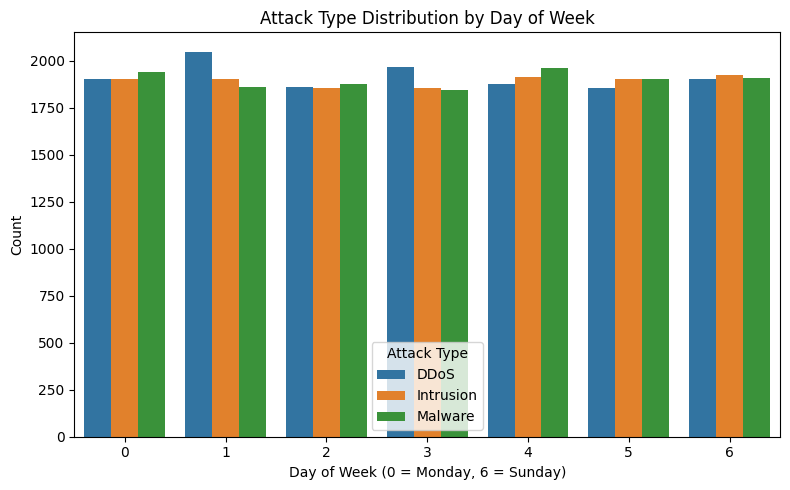

In [7]:


plt.figure(figsize=(8, 5))
sns.countplot(
    data=df,
    x="dayofweek",
    hue="Attack Type"
)

plt.title("Attack Type Distribution by Day of Week")
plt.xlabel("Day of Week (0 = Monday, 6 = Sunday)")
plt.ylabel("Count")
plt.legend(title="Attack Type")
plt.tight_layout()
plt.show()

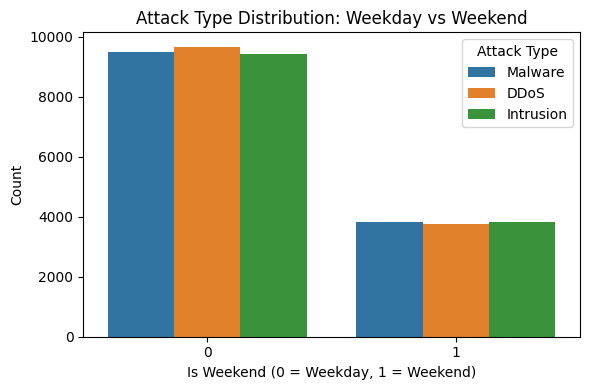

In [8]:
plt.figure(figsize=(6, 4))
sns.countplot(
    data=df,
    x="is_weekend",
    hue="Attack Type"
)

plt.title("Attack Type Distribution: Weekday vs Weekend")
plt.xlabel("Is Weekend (0 = Weekday, 1 = Weekend)")
plt.ylabel("Count")
plt.legend(title="Attack Type")
plt.tight_layout()
plt.show()

### Interpretation

The timestamp column was successfully parsed with 0 missing values, covering a coherent time range from 2020 to 2023, confirming its technical reliability.

Temporal features were extracted (hour, dayofweek, month, is_weekend) and analyzed against the target variable. The class distributions across days of the week were nearly uniform, with proportions ranging approximately between 13% and 15% for all attack types. Similarly, the distribution between weekdays and weekends showed no significant differences across classes.

Although no strong discriminative temporal pattern was observed, these features were retained as low-cost contextual information that does not introduce noise and may still contribute marginally when combined with other features in non-linear models.

## 2.2 IP Address features VS Attack Type
These variables correspond to the source and destination IP addresses of the network traffic and mainly behave as identifiers due to their very high cardinality.

In [9]:
# summary of unique values in Source and Destination IPs

print("Source IP unique values:", df["Source IP Address"].nunique())
print("Destination IP unique values:", df["Destination IP Address"].nunique())
print("Total rows:", len(df))


Source IP unique values: 40000
Destination IP unique values: 40000
Total rows: 40000


In [10]:
# review top 10 most frequent Source IPs

df["Source IP Address"].value_counts().head(10)


,count
Source IP Address,
138.156.5.40,1
24.150.253.66,1
188.133.58.141,1
113.228.203.251,1
209.70.190.115,1
122.163.144.175,1
24.231.154.145,1
99.127.94.207,1
134.187.11.18,1


In [11]:
# review top 10 most frequent Destination IPs

df["Destination IP Address"].value_counts().head(10)


,count
Destination IP Address,
91.54.135.213,1
163.192.200.17,1
25.179.17.77,1
9.92.96.13,1
189.175.162.204,1
35.82.104.31,1
194.39.139.141,1
5.75.50.154,1
152.152.206.57,1


In [12]:
# extract IP address features using ip_address library



def ip_features(ip):
    try:
        ip_obj = ipaddress.ip_address(ip)
        return pd.Series({
            "is_private": int(ip_obj.is_private),
            "is_global": int(ip_obj.is_global),
            "is_multicast": int(ip_obj.is_multicast)
        })
    except:
        return pd.Series({
            "is_private": np.nan,
            "is_global": np.nan,
            "is_multicast": np.nan
        })

src_ip_feats = df["Source IP Address"].apply(ip_features)
dst_ip_feats = df["Destination IP Address"].apply(ip_features)

src_ip_feats.head()


,is_private,is_global,is_multicast
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0


In [13]:
# distribution of attack types across private vs public Source IPs
pd.crosstab(df["Attack Type"], src_ip_feats["is_private"], normalize="index")

is_private,0,1
Attack Type,,
DDoS,0.995830,0.004170
Intrusion,0.995628,0.004372
Malware,0.994965,0.005035


In [14]:
# distribution of attack types across private vs public Destination IPs

pd.crosstab(df["Attack Type"], dst_ip_feats["is_private"], normalize="index")


is_private,0,1
Attack Type,,
DDoS,0.994936,0.005064
Intrusion,0.996306,0.003694
Malware,0.995717,0.004283


### Interpretation

Both Source IP Address and Destination IP Address exhibit extremely high cardinality, with 40,000 unique values for 40,000 observations, meaning that each IP appears only once in the dataset. Frequency analysis confirms the absence of recurring IP patterns, as the most frequent IPs appear a single time.

Simple derived features based on IP properties were evaluated, such as whether an IP address is private or public. Results show that approximately 99.5% of IPs are global, with only 0.4–0.5% private IPs, and this proportion is nearly identical across all attack types (DDoS, Intrusion, Malware). No meaningful variation or discriminative pattern was observed between classes.

These findings indicate that IP-related features behave as unique identifiers rather than generalizable predictors, and their inclusion would likely introduce noise and overfitting without improving model performance.

## 2.3 Network traffic features VS Attack Type
These variables indicate the network ports used by the source and destination machines and help identify the services or applications involved in the network traffic.

In [15]:
# handling missing values
for col in ["Source Port", "Destination Port"]:
    print(f"\n{col}")
    print("Missing:", df[col].isna().sum())
    print("Min:", df[col].min(), "Max:", df[col].max())


Source Port
Missing: 0
Min: 1027 Max: 65530

Destination Port
Missing: 0
Min: 1024 Max: 65535


In [16]:
# descriptive statistics for Source and Destination Ports

df[["Source Port", "Destination Port"]].describe()


,Source Port,Destination Port
count,40000.000000,40000.000000
mean,32970.356450,33150.868650
std,18560.425604,18574.668842
min,1027.000000,1024.000000
25%,16850.750000,17094.750000
50%,32856.000000,33004.500000
75%,48928.250000,49287.000000
max,65530.000000,65535.000000


In [17]:
# statistics by Attack Type
df.groupby("Attack Type")[["Source Port", "Destination Port"]].describe()

Source Port                                                        \
                  count          mean           std     min      25%      50%   
Attack Type                                                                     
DDoS            13428.0  32944.896932  18612.927467  1027.0  16782.5  32851.5   
Intrusion       13265.0  32987.208217  18561.266193  1031.0  16887.0  32687.0   
Malware         13307.0  32979.248892  18507.826405  1033.0  16931.0  33044.0   

                               Destination Port                              \
                  75%      max            count          mean           std   
Attack Type                                                                   
DDoS         49073.25  65530.0          13428.0  33207.363941  18622.747957   
Intrusion    49023.00  65525.0          13265.0  33227.405880  18541.304784   
Malware      48692.00  65530.0          13307.0  33017.563989  18559.986472   

                                                          
                min       25%      50%      75%      max  
Attack Type                                               
DDoS         1029.0  17089.25  32986.0  49302.5  65535.0  
Intrusion    1043.0  17228.00  33035.0  49586.0  65534.0  
Malware      1024.0  16995.50  32984.0  48928.0  65535.0

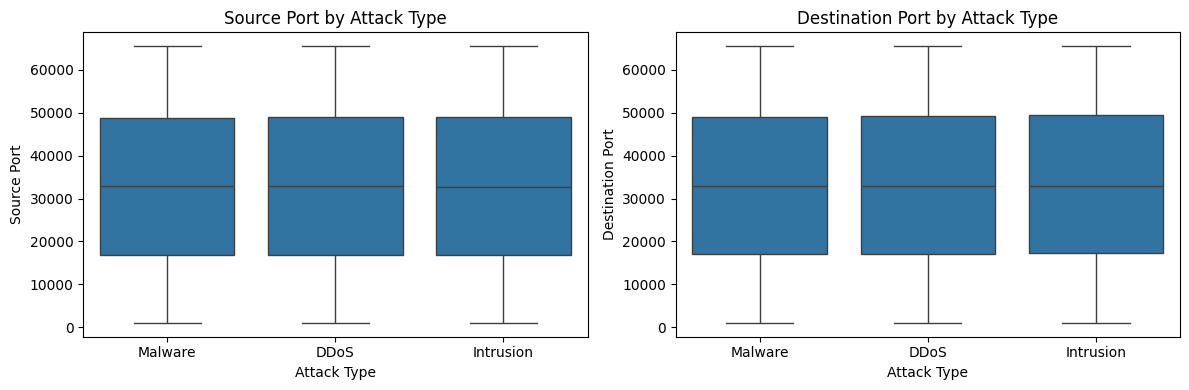

In [18]:
# data visualization: boxplots for Source and Destination Ports by Attack Type
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
sns.boxplot(x="Attack Type", y="Source Port", data=df)
plt.title("Source Port by Attack Type")

plt.subplot(1,2,2)
sns.boxplot(x="Attack Type", y="Destination Port", data=df)
plt.title("Destination Port by Attack Type")

plt.tight_layout()
plt.show()


### Interpretation

Both Source Port and Destination Port contain no missing values and fall within valid port ranges (1024–65535), confirming their technical validity.

Statistical analysis shows that the distributions of both ports are very similar across all attack types. Mean values are close to 33,000, with comparable standard deviations (~18,500) for DDoS, Intrusion, and Malware. Quartiles and medians are also nearly identical across classes.

Boxplots further confirm that the distributions are heavily overlapping, with no clear separation between attack types. This indicates that port numbers alone do not strongly discriminate between classes.

However, ports still carry contextual network information (e.g., well-known vs ephemeral ports) and may contribute to performance when combined with other features in non-linear models.

## 2.4 Protocol VS Attack Type
It describes the communication protocol used and provides context regarding the nature of the network traffic.

In [19]:
# summary of unique values in Protocol
df["Protocol"].value_counts()

,count
Protocol,
ICMP,13429
UDP,13299
TCP,13272


In [20]:
# distribution of attack types across Protocols

pd.crosstab(df["Attack Type"], df["Protocol"], normalize="index")


Protocol,ICMP,TCP,UDP
Attack Type,,,
DDoS,0.335716,0.330503,0.333780
Intrusion,0.336223,0.331474,0.332303
Malware,0.335237,0.333434,0.331329


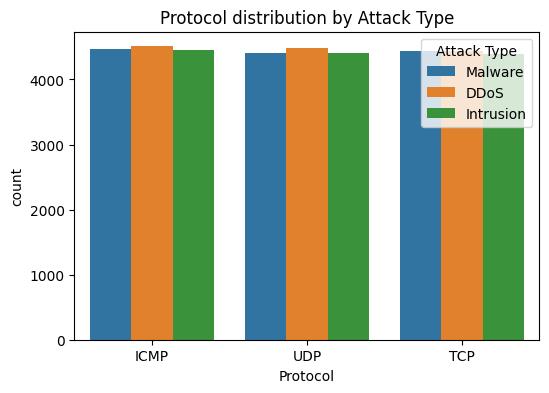

In [21]:
# Data visualization of Protocol distribution by Attack Type
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="Protocol", hue="Attack Type")
plt.title("Protocol distribution by Attack Type")
plt.show()


### Interpretation

The Protocol feature contains three categories (ICMP, UDP, TCP) with an almost perfectly balanced global distribution (≈ 13,300 observations per protocol).

When analyzed by attack type, the proportions of protocols are nearly identical across all classes. For each attack type (DDoS, Intrusion, Malware), the distribution remains stable at approximately 33% ICMP, 33% TCP, and 33% UDP. The bar plot confirms a strong overlap between classes, indicating no strong standalone discriminative power.

Despite the absence of clear separation when considered individually, the protocol still represents fundamental network-layer information and may contribute useful interactions when combined with other features in non-linear models.

## 2.5 Packet Length VS Attack Type
This variable measures the size of network packets in bytes and may reflect certain characteristics of network behavior.

In [22]:
# handling missing values and checking logical bounds for Packet Length
print("Missing values:", df["Packet Length"].isna().sum())
print("Min:", df["Packet Length"].min())
print("Max:", df["Packet Length"].max())

Missing values: 0
Min: 64
Max: 1500


In [23]:
# summary statistics for Packet Length
df["Packet Length"].describe()

,Packet Length
count,40000.000000
mean,781.452725
std,416.044192
min,64.000000
25%,420.000000
50%,782.000000
75%,1143.000000
max,1500.000000


In [24]:
# distribution of Packet Length by Attack Type

df.groupby("Attack Type")["Packet Length"].describe()

,count,mean,std,min,25%,50%,75%,max
Attack Type,,,,,,,,
DDoS,13428.0,785.348749,416.685412,64.0,424.0,786.0,1150.0,1500.0
Intrusion,13265.0,780.924387,418.209936,64.0,412.0,785.0,1145.0,1500.0
Malware,13307.0,778.047945,413.221127,64.0,426.0,777.0,1135.0,1500.0


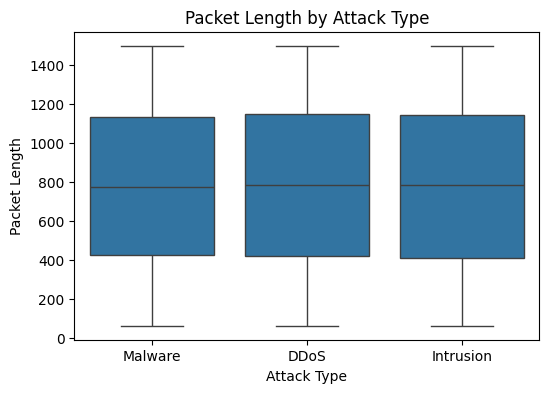

In [25]:
# plotting Packet Length distribution by Attack Type
plt.figure(figsize=(6,4))
sns.boxplot(x="Attack Type", y="Packet Length", data=df)
plt.title("Packet Length by Attack Type")
plt.show()


### Interpretation

The Packet Length feature contains no missing values and falls within a realistic range for network traffic (64 to 1500 bytes). The global distribution shows a mean of approximately 781 bytes with a median around 782 bytes, indicating a fairly symmetric distribution.

When analyzed by attack type, the distributions of packet length are highly similar across all classes. Mean values are close (778–785 bytes) with comparable standard deviations (413–418 bytes). Boxplots confirm a strong overlap between DDoS, Intrusion, and Malware, with no clear separation or class-specific pattern.

Although Packet Length does not exhibit strong standalone discriminative power, it represents fundamental traffic characteristics and may still contribute useful signal when combined with other features in non-linear models.

## 2.6 Packet Type and Traffic Type VS Attack type
These variables describe the structure and application context of the network traffic by indicating the type of packet exchanged and the associated traffic category.

In [26]:
# summary of unique values in Packet Type and Traffic Type

print("Packet Type distribution:")
display(df["Packet Type"].value_counts())

print("\nTraffic Type distribution:")
display(df["Traffic Type"].value_counts())


Packet Type distribution:


,count
Packet Type,
Control,20237
Data,19763



Traffic Type distribution:


,count
Traffic Type,
DNS,13376
HTTP,13360
FTP,13264


In [27]:
# distribution of Packet Type and Traffic Type by Attack Type

print("Packet Type by Attack Type:")
display(pd.crosstab(df["Attack Type"], df["Packet Type"], normalize="index"))

print("\nTraffic Type by Attack Type:")
display(pd.crosstab(df["Attack Type"], df["Traffic Type"], normalize="index"))


Packet Type by Attack Type:


Packet Type,Control,Data
Attack Type,,
DDoS,0.497394,0.502606
Intrusion,0.509235,0.490765
Malware,0.511235,0.488765



Traffic Type by Attack Type:


Traffic Type,DNS,FTP,HTTP
Attack Type,,,
DDoS,0.337206,0.326854,0.335940
Intrusion,0.333660,0.335695,0.330645
Malware,0.332306,0.332306,0.335387


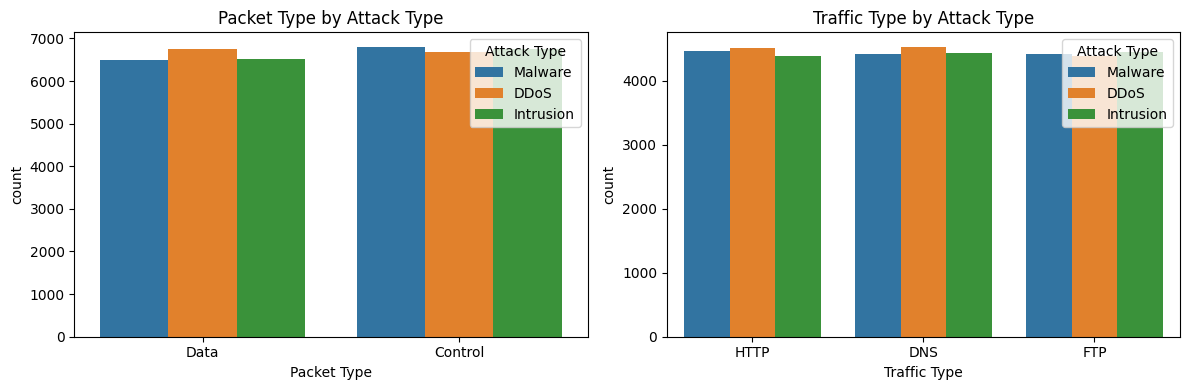

In [28]:
# Data visualization of Packet Type and Traffic Type distribution by Attack Type

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
sns.countplot(data=df, x="Packet Type", hue="Attack Type")
plt.title("Packet Type by Attack Type")

plt.subplot(1,2,2)
sns.countplot(data=df, x="Traffic Type", hue="Attack Type")
plt.title("Traffic Type by Attack Type")

plt.tight_layout()
plt.show()


### Interpretation

Both Packet Type and Traffic Type are low-cardinality categorical features with balanced global distributions. Packet Type is almost evenly split between Control (≈50.6%) and Data (≈49.4%), while Traffic Type is uniformly distributed across DNS, HTTP, and FTP (each ≈33%).

When analyzed by attack type, the class-wise proportions remain highly consistent across all categories. For Packet Type, the Control/Data split varies only slightly between attack types (within ~1–2%). Similarly, Traffic Type shows no significant variation across DDoS, Intrusion, and Malware, with proportions remaining close to one-third for each category.

Although neither feature shows strong standalone discriminative power, both represent core network characteristics and may contribute useful interactions when combined with other variables in non-linear models.

## 2.7 Payload Data VS Attack type
It contains the raw content of network packets but exhibits very high cardinality and unstructured characteristics.

In [29]:
# summary of unique values and missing values in Payload Data

print("Missing values:", df["Payload Data"].isna().sum())
print("Unique values:", df["Payload Data"].nunique())
print("Total rows:", len(df))


Missing values: 0
Unique values: 40000
Total rows: 40000


In [30]:
# descriptive statistics for Payload Data length

df["payload_len"] = df["Payload Data"].str.len()

df["payload_len"].describe()


,payload_len
count,40000.000000
mean,141.173875
std,36.526330
min,22.000000
25%,114.000000
50%,144.000000
75%,172.000000
max,199.000000


In [31]:
# distribution of Payload Data length by Attack Type

df.groupby("Attack Type")["payload_len"].describe()


,count,mean,std,min,25%,50%,75%,max
Attack Type,,,,,,,,
DDoS,13428.0,141.438487,36.728812,24.0,114.0,144.0,172.0,199.0
Intrusion,13265.0,140.816736,36.278761,22.0,114.0,143.0,171.0,199.0
Malware,13307.0,141.262869,36.567299,22.0,114.0,144.0,172.0,199.0


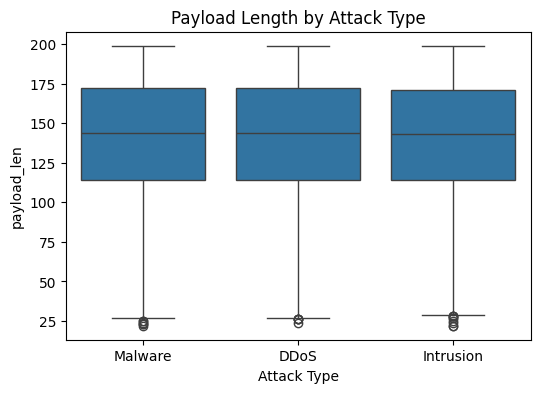

In [32]:
# plotting Payload Length distribution by Attack Type



plt.figure(figsize=(6,4))
sns.boxplot(x="Attack Type", y="payload_len", data=df)
plt.title("Payload Length by Attack Type")
plt.show()


### Interpretation

The Payload Data feature contains no missing values and exhibits maximum cardinality, with 40,000 unique payloads for 40,000 observations, indicating that each payload is essentially unique.

Payload length analysis shows a very consistent distribution across attack types. The average payload length is approximately 141 characters, with nearly identical medians (143–144 characters) and standard deviations (36 characters) for DDoS, Intrusion, and Malware. Boxplots confirm a strong overlap between classes, with no visible separation or class-specific patterns.

These results indicate that payload content in this dataset is highly unstructured and non-discriminative, behaving more like random text than meaningful attack signatures. As such, payload-based features do not provide useful predictive signal and would likely introduce noise and unnecessary computational cost.

## 2.8 Security signal features (logs, alerts, signatures) VS Attack Type
These variables indicate whether security systems detected suspicious or malicious activity during the event, including malware indicators, alerts, firewall logs, or IDS/IPS notifications.

In [33]:
# summary of unique values and missing values in alert-related columns

alert_cols = [
    "Malware Indicators",
    "Alerts/Warnings",
    "Firewall Logs",
    "IDS/IPS Alerts"
]

for col in alert_cols:
    print(f"\n{col}")
    print("Missing %:", round(df[col].isna().mean() * 100, 2))
    print("Unique values:", df[col].nunique(dropna=True))
    print("Top values:")
    print(df[col].value_counts(dropna=True).head())



Malware Indicators
Missing %: 50.0
Unique values: 1
Top values:
Malware Indicators
IoC Detected    20000
Name: count, dtype: int64

Alerts/Warnings
Missing %: 50.17
Unique values: 1
Top values:
Alerts/Warnings
Alert Triggered    19933
Name: count, dtype: int64

Firewall Logs
Missing %: 49.9
Unique values: 1
Top values:
Firewall Logs
Log Data    20039
Name: count, dtype: int64

IDS/IPS Alerts
Missing %: 50.12
Unique values: 1
Top values:
IDS/IPS Alerts
Alert Data    19950
Name: count, dtype: int64


In [34]:
# creating binary features for presence of alerts

for col in alert_cols:
    df[col + "_present"] = df[col].notna().astype(int)

df[[c + "_present" for c in alert_cols]].head()


,Malware Indicators_present,Alerts/Warnings_present,Firewall Logs_present,IDS/IPS Alerts_present
0,1,0,1,0
1,1,0,1,0
2,1,1,1,1
3,0,1,0,1
4,0,1,0,1


In [35]:
# Attack Type vs Alert Presence Crosstab Analysis

for col in alert_cols:
    print(f"\n{col}_present")
    display(pd.crosstab(
        df["Attack Type"],
        df[col + "_present"],
        normalize="index"
    ))



Malware Indicators_present


Malware Indicators_present,0,1
Attack Type,,
DDoS,0.504468,0.495532
Intrusion,0.497550,0.502450
Malware,0.497933,0.502067



Alerts/Warnings_present


Alerts/Warnings_present,0,1
Attack Type,,
DDoS,0.503053,0.496947
Intrusion,0.508104,0.491896
Malware,0.493875,0.506125



Firewall Logs_present


Firewall Logs_present,0,1
Attack Type,,
DDoS,0.500149,0.499851
Intrusion,0.500716,0.499284
Malware,0.496205,0.503795



IDS/IPS Alerts_present


IDS/IPS Alerts_present,0,1
Attack Type,,
DDoS,0.501266,0.498734
Intrusion,0.503430,0.496570
Malware,0.499061,0.500939


### Intepretation

All four variables exhibit a very similar structure: approximately 50% missing values and a single non-null value in each column (e.g., “IoC Detected”, “Alert Triggered”, “Log Data”, “Alert Data”). This confirms that the textual content itself does not carry any variability or additional information.

Binary indicators were therefore created to capture the presence or absence of these events. Analysis of the resulting binary features shows that their distributions are nearly identical across all attack types. For each feature, the proportion of presence versus absence remains close to 50% for DDoS, Intrusion, and Malware, with differences below 1% between classes.

Although these indicators do not demonstrate strong standalone discriminative power, they represent security-relevant signals (alerts, logs, indicators of compromise) and are low-cost binary features that may still contribute marginally through interactions in ensemble or non-linear models.

## 2.9 Anomaly score VS Attack type
It provides a numerical score representing the level of anomaly detected for a given event and serves as a key indicator of suspicious behavior.

In [36]:
# summary of unique values and missing values in Anomaly Scores

print("Missing values:", df["Anomaly Scores"].isna().sum())
print("Min:", df["Anomaly Scores"].min())
print("Max:", df["Anomaly Scores"].max())


Missing values: 0
Min: 0.0
Max: 100.0


In [37]:
# descriptive statistics for Anomaly Scores

df["Anomaly Scores"].describe()


,Anomaly Scores
count,40000.000000
mean,50.113473
std,28.853598
min,0.000000
25%,25.150000
50%,50.345000
75%,75.030000
max,100.000000


In [38]:
# statistics by Attack Type

df.groupby("Attack Type")["Anomaly Scores"].describe()


,count,mean,std,min,25%,50%,75%,max
Attack Type,,,,,,,,
DDoS,13428.0,50.235063,28.857465,0.00,25.470,50.42,75.07,99.99
Intrusion,13265.0,49.978029,28.815402,0.00,24.840,50.18,74.69,100.00
Malware,13307.0,50.125794,28.889315,0.01,25.055,50.42,75.28,99.99


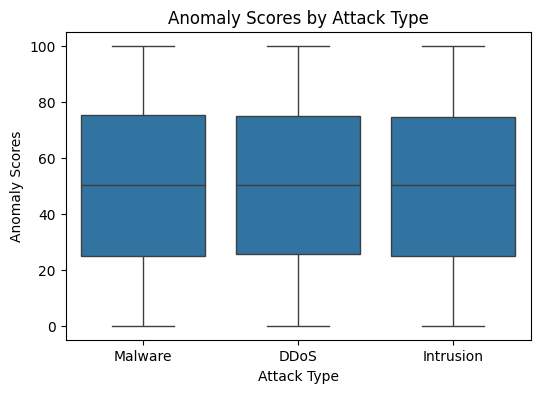

In [39]:
# plotting Anomaly Scores distribution by Attack Type

plt.figure(figsize=(6,4))
sns.boxplot(x="Attack Type", y="Anomaly Scores", data=df)
plt.title("Anomaly Scores by Attack Type")
plt.show()


### Interpretation

The Anomaly Scores feature shows excellent data quality, with 0% missing values and a clearly defined range between 0 and 100, indicating a normalized or bounded anomaly scoring system.

Globally, the distribution is centered around 50 (mean ≈ 50.1, median ≈ 50.3), with a symmetric spread (standard deviation ≈ 28.9). This suggests a well-balanced score distribution without extreme skewness.

When analyzed by attack type (DDoS, Intrusion, Malware), the statistical properties are remarkably similar:

Mean values range narrowly between 49.98 and 50.24

Medians are almost identical (≈ 50.2 – 50.4)

Interquartile ranges and overall distributions largely overlap

The boxplot confirms this observation, showing no clear separation between attack classes. Therefore, Anomaly Scores alone does not provide strong discriminative power for distinguishing attack types.

However, as a continuous numerical feature summarizing anomaly intensity, it may still contribute useful signal in combination with other features, especially in tree-based or ensemble models.

## 2.10 Attack Signature & Action Taken VS Attack Type
These variables describe the detected attack pattern and the response applied by the security system following the detection.

In [40]:
# Data Quality Check for Categorical Labels (Attack Signature, Action Taken)

for col in ["Attack Signature", "Action Taken"]:
    print(f"\n Data quality — {col}")
    print("Missing values:", df[col].isna().sum())
    print("Missing %:", round(df[col].isna().mean() * 100, 2))
    print("Unique values:", df[col].nunique(dropna=True))
    print(df[col].value_counts(dropna=True))



 Data quality — Attack Signature
Missing values: 0
Missing %: 0.0
Unique values: 2
Attack Signature
Known Pattern A    20076
Known Pattern B    19924
Name: count, dtype: int64

 Data quality — Action Taken
Missing values: 0
Missing %: 0.0
Unique values: 3
Action Taken
Blocked    13529
Ignored    13276
Logged     13195
Name: count, dtype: int64


In [41]:
# distribution of Attack Signature and Action Taken by Attack Type

for col in ["Attack Signature", "Action Taken"]:
    print(f"\n{col} by Attack Type (row-wise proportions)")
    display(
        pd.crosstab(
            df["Attack Type"],
            df[col],
            normalize="index"
        )
    )



Attack Signature by Attack Type (row-wise proportions)


Attack Signature,Known Pattern A,Known Pattern B
Attack Type,,
DDoS,0.498808,0.501192
Intrusion,0.506370,0.493630
Malware,0.500564,0.499436



Action Taken by Attack Type (row-wise proportions)


Action Taken,Blocked,Ignored,Logged
Attack Type,,,
DDoS,0.337578,0.332067,0.330354
Intrusion,0.343234,0.331775,0.324991
Malware,0.333884,0.331855,0.334260


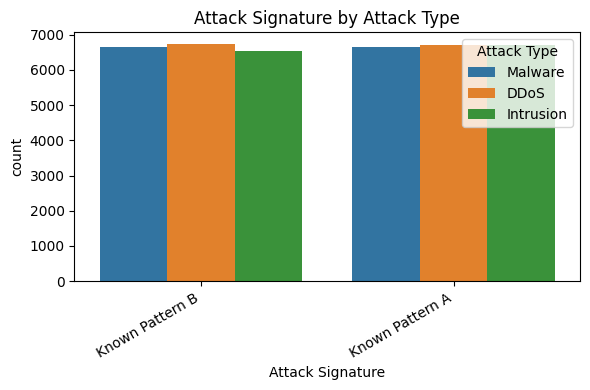

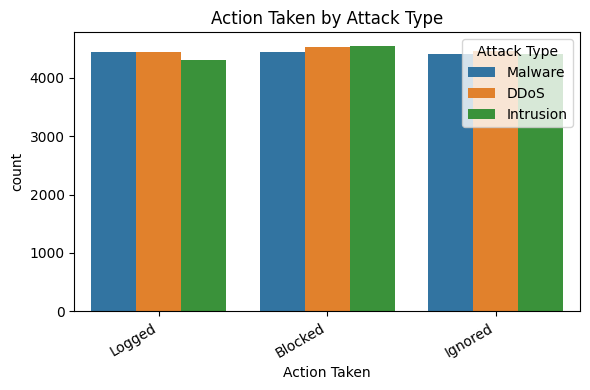

In [42]:
# Data visualization of Attack Signature and Action Taken distribution by Attack Type

for col in ["Attack Signature", "Action Taken"]:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df, x=col, hue="Attack Type")
    plt.title(f"{col} by Attack Type")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()


### Interpretation

Attack Signature exhibits excellent data quality, with 0% missing values and only two unique categories (Known Pattern A and Known Pattern B), distributed almost perfectly evenly across the dataset. Analysis of row-wise proportions by attack type shows that the distribution of signatures is nearly identical for DDoS, Intrusion, and Malware, with differences below 1% between classes. This indicates that Attack Signature does not provide strong standalone discriminative power for predicting the attack type.

Action Taken also demonstrates high data quality, with no missing values and three well-balanced categories (Blocked, Ignored, Logged). Similar to Attack Signature, its distribution across attack types is highly uniform. For each class, the proportions of the three actions remain close to one-third each, and no action is clearly associated with a specific attack type.

Despite the lack of strong class separation, both variables have low cardinality, clean semantics, and no noise, making them inexpensive features to include. However, it is important to note that Action Taken represents a post-detection response, which introduces a potential risk of target leakage in real-world deployment scenarios where this information may not be available at prediction time.

## 2.11 Severity level VS Attack Type
This variable represents the severity level assigned to the security event.

In [43]:
# Summary of unique values and missing values in Severity Level

col = "Severity Level"

print("Missing values:", df[col].isna().sum())
print("Missing %:", round(df[col].isna().mean()*100, 2))
print("Unique values:", df[col].nunique(dropna=True))

df[col].value_counts(dropna=True)


Missing values: 0
Missing %: 0.0
Unique values: 3


,count
Severity Level,
Medium,13435
High,13382
Low,13183


In [44]:
# Overall distribution

df["Severity Level"].value_counts(normalize=True)


,proportion
Severity Level,
Medium,0.335875
High,0.334550
Low,0.329575


In [45]:
# Severity Level distribution by Attack Type

pd.crosstab(
    df["Attack Type"],
    df["Severity Level"],
    normalize="index"
)


Severity Level,High,Low,Medium
Attack Type,,,
DDoS,0.336833,0.331397,0.331769
Intrusion,0.333735,0.329740,0.336525
Malware,0.333058,0.327572,0.339370


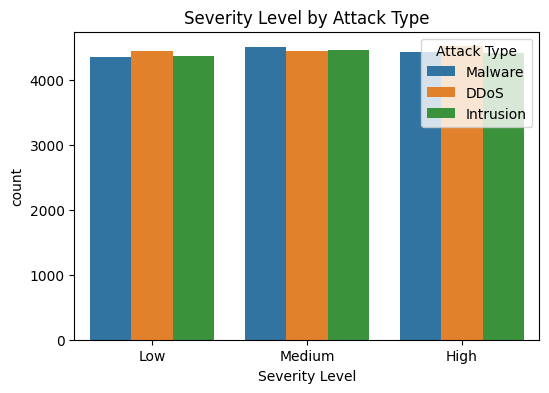

In [46]:
# visualization of Severity Level by Attack Type

plt.figure(figsize=(6,4))
sns.countplot(data=df, x="Severity Level", hue="Attack Type")
plt.title("Severity Level by Attack Type")
plt.show()


### Interpretation

The Severity Level feature contains no missing values and has low cardinality, with only three distinct categories (Low, Medium, High), making it a clean and well-structured categorical variable.

The overall distribution is remarkably balanced, with each severity level representing roughly one third of the dataset: Medium (33.6%), High (33.5%), and Low (33.0%). This balance ensures that no single severity class dominates the data and reduces the risk of bias during model training.

When analyzed by Attack Type, severity proportions remain highly consistent across classes. For DDoS, Intrusion, and Malware, each severity level accounts for approximately one third of the observations, with only marginal variations (all differences < 1%). The countplot confirms this pattern visually, showing nearly identical bar heights across attack types and severity levels, with no noticeable separation or class-specific trends.

Overall, Severity Level does not exhibit strong discriminative power with respect to the attack type. Instead, it behaves as a uniform contextual descriptor, suggesting that severity assignment in this dataset is largely independent of the attack category. While the feature is clean and reliable, its standalone predictive contribution is likely limited. It may nonetheless remain useful when combined with other features or in interaction-based models.

## 2.12 User & device Information VS Attack Type

In [47]:
# Summary of unique values and missing values in User Information

col = "User Information"

print("Missing values:", df[col].isna().sum())
print("Missing %:", round(df[col].isna().mean()*100, 2))
print("Unique values:", df[col].nunique(dropna=True))

df[col].value_counts(dropna=True).head(10)


Missing values: 0
Missing %: 0.0
Unique values: 32389


,count
User Information,
Heer Lad,6
Ishaan Chaudhari,6
Akarsh Tripathi,5
Ishita Chaudry,5
Aradhya Chaudhry,5
Elakshi Koshy,5
Urvi Dara,5
Jayan Kala,5
Baiju Dugar,5


In [48]:
# Top frequent users

df["User Information"].value_counts(normalize=True).head(10)


,proportion
User Information,
Heer Lad,0.000150
Ishaan Chaudhari,0.000150
Akarsh Tripathi,0.000125
Ishita Chaudry,0.000125
Aradhya Chaudhry,0.000125
Elakshi Koshy,0.000125
Urvi Dara,0.000125
Jayan Kala,0.000125
Baiju Dugar,0.000125


In [49]:
# User Information vs Attack Type (top users only)

top_users = df["User Information"].value_counts().head(20).index

pd.crosstab(
    df.loc[df["User Information"].isin(top_users), "Attack Type"],
    df.loc[df["User Information"].isin(top_users), "User Information"],
    normalize="index"
)


User Information,Akarsh Tripathi,Aradhya Chaudhry,Azad Kala,Baiju Dugar,Elakshi Koshy,Elakshi Mandal,Heer Lad,Ishaan Chaudhari,Ishita Chaudry,Jayan Kala,Mahika Sachdev,Nakul Krishna,Nayantara Krishnamurthy,Nirvi Kurian,Renee Jayaraman,Tara Madan,Urvi Dara,Urvi Mani,Vritika Dara,Yasmin Ghose
Attack Type,,,,,,,,,,,,,,,,,,,,
DDoS,0.034483,0.103448,0.103448,0.103448,0.000000,0.034483,0.172414,0.000000,0.034483,0.034483,0.034483,0.068966,0.034483,0.068966,0.000000,0.000000,0.068966,0.000000,0.068966,0.034483
Intrusion,0.027027,0.000000,0.054054,0.000000,0.081081,0.054054,0.027027,0.027027,0.027027,0.081081,0.054054,0.081081,0.000000,0.054054,0.054054,0.135135,0.054054,0.081081,0.027027,0.081081
Malware,0.093750,0.062500,0.000000,0.062500,0.062500,0.031250,0.000000,0.156250,0.093750,0.031250,0.062500,0.000000,0.093750,0.000000,0.062500,0.000000,0.031250,0.062500,0.062500,0.031250


In [50]:
# unique/rows ratio for User Information

n_unique = df["User Information"].nunique()
n_rows = len(df)

print("Unique / Rows ratio:", round(n_unique / n_rows, 3))


Unique / Rows ratio: 0.81


### Interpretation

The User Information feature contains no missing values and exhibits extremely high cardinality, with 32,389 unique values for approximately 40,000 observations, resulting in a unique-to-rows ratio of 0.81. This indicates that the vast majority of users appear only once or a very limited number of times in the dataset.

The frequency distribution confirms this sparsity: even the most frequent users occur only 5 to 6 times, each representing less than 0.02% of the dataset. This long-tail distribution is characteristic of identifier-like variables rather than meaningful behavioral aggregates.

When analyzed against Attack Type, no stable or interpretable patterns emerge. The row-wise proportions across users are highly fragmented, with values driven by very small sample counts rather than systematic relationships. Apparent variations in proportions are attributable to randomness and low support rather than genuine associations between specific users and attack categories.

Overall, User Information behaves as a quasi-unique identifier rather than a predictive feature. Its high cardinality, extreme sparsity, and lack of consistent relationship with the target suggest no discriminative value for attack type prediction. Including this feature in a model would likely introduce noise, increase dimensionality, and risk overfitting without providing meaningful signal.

## 2.13 Device Information
This variable describes the device or equipment involved in the event, often represented as highly specific strings.

In [51]:
# Summary of unique values and missing values in Device Information

col = "Device Information"

print("Missing values:", df[col].isna().sum())
print("Missing %:", round(df[col].isna().mean()*100, 2))
print("Unique values:", df[col].nunique(dropna=True))

df[col].value_counts(dropna=True).head(10)


Missing values: 0
Missing %: 0.0
Unique values: 32104


,count
Device Information,
Mozilla/5.0 (compatible; MSIE 6.0; Windows NT 6.2; Trident/3.0),35
Mozilla/5.0 (compatible; MSIE 5.0; Windows 98; Trident/4.1),34
Mozilla/5.0 (compatible; MSIE 6.0; Windows CE; Trident/4.0),33
Mozilla/5.0 (compatible; MSIE 5.0; Windows NT 5.2; Trident/4.1),31
Mozilla/5.0 (compatible; MSIE 7.0; Windows NT 6.0; Trident/3.0),31
Mozilla/5.0 (compatible; MSIE 8.0; Windows CE; Trident/3.0),30
Mozilla/5.0 (compatible; MSIE 8.0; Windows NT 5.1; Trident/3.1),30
Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 10.0; Trident/4.0),30
Mozilla/5.0 (compatible; MSIE 8.0; Windows NT 6.1; Trident/4.0),30


In [52]:
# Top frequent devices

df["Device Information"].value_counts(normalize=True).head(10)


,proportion
Device Information,
Mozilla/5.0 (compatible; MSIE 6.0; Windows NT 6.2; Trident/3.0),0.000875
Mozilla/5.0 (compatible; MSIE 5.0; Windows 98; Trident/4.1),0.000850
Mozilla/5.0 (compatible; MSIE 6.0; Windows CE; Trident/4.0),0.000825
Mozilla/5.0 (compatible; MSIE 5.0; Windows NT 5.2; Trident/4.1),0.000775
Mozilla/5.0 (compatible; MSIE 7.0; Windows NT 6.0; Trident/3.0),0.000775
Mozilla/5.0 (compatible; MSIE 8.0; Windows CE; Trident/3.0),0.000750
Mozilla/5.0 (compatible; MSIE 8.0; Windows NT 5.1; Trident/3.1),0.000750
Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 10.0; Trident/4.0),0.000750
Mozilla/5.0 (compatible; MSIE 8.0; Windows NT 6.1; Trident/4.0),0.000750


In [53]:
# Device Information vs Attack Type (top devices only)

top_devices = df["Device Information"].value_counts().head(20).index

pd.crosstab(
    df.loc[df["Device Information"].isin(top_devices), "Attack Type"],
    df.loc[df["Device Information"].isin(top_devices), "Device Information"],
    normalize="index"
)


Device Information,Mozilla/5.0 (compatible; MSIE 5.0; Windows 98; Trident/3.0),Mozilla/5.0 (compatible; MSIE 5.0; Windows 98; Trident/4.1),Mozilla/5.0 (compatible; MSIE 5.0; Windows CE; Trident/3.0),Mozilla/5.0 (compatible; MSIE 5.0; Windows NT 5.2; Trident/4.1),Mozilla/5.0 (compatible; MSIE 5.0; Windows NT 6.0; Trident/5.0),Mozilla/5.0 (compatible; MSIE 6.0; Windows CE; Trident/4.0),Mozilla/5.0 (compatible; MSIE 6.0; Windows NT 6.2; Trident/3.0),Mozilla/5.0 (compatible; MSIE 7.0; Windows 98; Trident/3.1),Mozilla/5.0 (compatible; MSIE 7.0; Windows NT 5.2; Trident/4.1),Mozilla/5.0 (compatible; MSIE 7.0; Windows NT 6.0; Trident/3.0),Mozilla/5.0 (compatible; MSIE 7.0; Windows NT 6.1; Trident/4.0),Mozilla/5.0 (compatible; MSIE 8.0; Windows 95; Trident/4.0),Mozilla/5.0 (compatible; MSIE 8.0; Windows CE; Trident/3.0),Mozilla/5.0 (compatible; MSIE 8.0; Windows NT 5.1; Trident/3.1),Mozilla/5.0 (compatible; MSIE 8.0; Windows NT 6.0; Trident/5.1),Mozilla/5.0 (compatible; MSIE 8.0; Windows NT 6.1; Trident/4.0),Mozilla/5.0 (compatible; MSIE 9.0; Windows 98; Trident/4.0),Mozilla/5.0 (compatible; MSIE 9.0; Windows CE; Trident/3.1),Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 10.0; Trident/4.0),Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 5.2; Trident/5.1)
Attack Type,,,,,,,,,,,,,,,,,,,,
DDoS,0.060914,0.050761,0.050761,0.030457,0.071066,0.020305,0.071066,0.045685,0.055838,0.065990,0.050761,0.045685,0.045685,0.045685,0.030457,0.065990,0.050761,0.060914,0.040609,0.040609
Intrusion,0.040609,0.050761,0.035533,0.060914,0.030457,0.055838,0.030457,0.055838,0.045685,0.060914,0.040609,0.050761,0.060914,0.050761,0.071066,0.060914,0.035533,0.025381,0.081218,0.055838
Malware,0.039024,0.068293,0.053659,0.063415,0.043902,0.087805,0.073171,0.048780,0.039024,0.029268,0.053659,0.048780,0.043902,0.053659,0.043902,0.024390,0.053659,0.053659,0.029268,0.048780


In [54]:
# unique/rows ratio for Device Information

n_unique = df["Device Information"].nunique()
n_rows = len(df)

print("Unique / Rows ratio:", round(n_unique / n_rows, 3))


Unique / Rows ratio: 0.803


### Interpretation

The Device Information feature contains no missing values and shows very high cardinality, with 32,104 unique values across approximately 40,000 observations, corresponding to a unique-to-rows ratio of 0.80. This indicates that most device identifiers appear only once or a very limited number of times in the dataset.

The frequency distribution confirms a strong long-tail pattern. Even the most frequent device strings occur only 30 to 35 times, each representing less than 0.1% of the dataset. This suggests that the feature behaves more like a raw user-agent identifier than a compact representation of device characteristics.

Analysis by Attack Type does not reveal any consistent or stable patterns. The row-wise proportions across device strings are highly fragmented and fluctuate due to very small sample sizes. Apparent differences between attack categories are driven by noise rather than meaningful associations, and no device signature appears to be systematically linked to a specific attack type.

Overall, Device Information acts as a high-cardinality, sparsely populated identifier rather than a discriminative feature. Direct inclusion in a predictive model would significantly increase dimensionality, introduce sparsity, and raise the risk of overfitting without delivering reliable predictive signal.

## 2.14 Network segment VS Attack Type
It indicates the network segment in which the event occurred, providing infrastructural context.

In [55]:
# Summary of unique values and missing values in Network Segment

col = "Network Segment"

print("Missing values:", df[col].isna().sum())
print("Missing %:", round(df[col].isna().mean()*100, 2))
print("Unique values:", df[col].nunique(dropna=True))

df[col].value_counts(dropna=True)


Missing values: 0
Missing %: 0.0
Unique values: 3


,count
Network Segment,
Segment C,13408
Segment B,13319
Segment A,13273


In [56]:
# Overall distribution

df["Network Segment"].value_counts(normalize=True)


,proportion
Network Segment,
Segment C,0.335200
Segment B,0.332975
Segment A,0.331825


In [57]:
# Network Segment distribution by Attack Type

pd.crosstab(
    df["Attack Type"],
    df["Network Segment"],
    normalize="index"
)


Network Segment,Segment A,Segment B,Segment C
Attack Type,,,
DDoS,0.331025,0.332589,0.336387
Intrusion,0.327855,0.339012,0.333132
Malware,0.336590,0.327347,0.336064


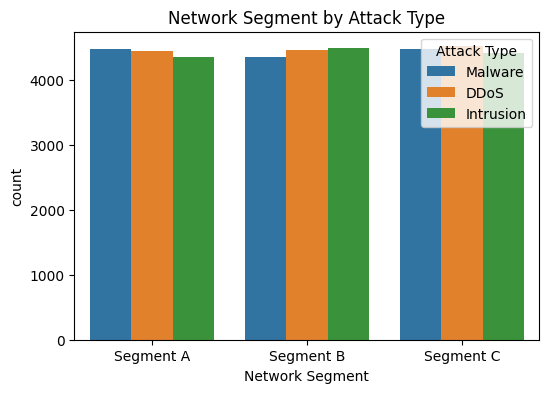

In [58]:
# visualization of Network Segment by Attack Type

plt.figure(figsize=(6,4))
sns.countplot(data=df, x="Network Segment", hue="Attack Type")
plt.title("Network Segment by Attack Type")
plt.show()


### Interpretation

The Network Segment feature contains no missing values and has very low cardinality, with only three distinct categories (Segment A, Segment B, Segment C), making it a clean and well-structured categorical variable.

The overall distribution is highly balanced, with each segment representing roughly one third of the dataset: Segment C (33.5%), Segment B (33.3%), and Segment A (33.2%). This balance minimizes bias and ensures uniform representation across network segments.

When analyzed by Attack Type, the segment proportions remain remarkably consistent across DDoS, Intrusion, and Malware. For each attack category, all three network segments contribute close to one third of the observations, with only marginal deviations (generally below 1%). The countplot visually confirms this uniformity, showing nearly identical bar heights across segments and attack types, with no visible class-specific patterns.

Overall, Network Segment does not display strong discriminative power with respect to attack type. Instead, it behaves as a contextual or infrastructural descriptor, suggesting that attacks are evenly distributed across network segments in this dataset. While the feature is clean and stable, its standalone predictive contribution is expected to be limited. It may still provide value in interaction with other network-level features or in rule-based analyses.

## 2.15 Geo-location VS Attack Type
This variable provides geographic information that may be associated with the origin or destination of the traffic.

In [59]:
# Summary of unique values and missing values in Geo-location Data

col = "Geo-location Data"

print("Missing values:", df[col].isna().sum())
print("Missing %:", round(df[col].isna().mean()*100, 2))
print("Unique values:", df[col].nunique(dropna=True))

df[col].value_counts(dropna=True).head(10)


Missing values: 0
Missing %: 0.0
Unique values: 8723


,count
Geo-location Data,
"Ghaziabad, Meghalaya",16
"Kalyan-Dombivli, Jharkhand",15
"Ghaziabad, Uttarakhand",14
"Ghaziabad, Tripura",14
"Motihari, Odisha",13
"Srikakulam, Uttarakhand",13
"Yamunanagar, Arunachal Pradesh",13
"Kottayam, Nagaland",13
"Ghaziabad, Jharkhand",13


In [60]:
# Top frequent geo-locations

df["Geo-location Data"].value_counts(normalize=True).head(10)


,proportion
Geo-location Data,
"Ghaziabad, Meghalaya",0.000400
"Kalyan-Dombivli, Jharkhand",0.000375
"Ghaziabad, Uttarakhand",0.000350
"Ghaziabad, Tripura",0.000350
"Motihari, Odisha",0.000325
"Srikakulam, Uttarakhand",0.000325
"Yamunanagar, Arunachal Pradesh",0.000325
"Kottayam, Nagaland",0.000325
"Ghaziabad, Jharkhand",0.000325


In [61]:
# Geo-location vs Attack Type (top locations)

top_locations = df["Geo-location Data"].value_counts().head(20).index

pd.crosstab(
    df.loc[df["Geo-location Data"].isin(top_locations), "Attack Type"],
    df.loc[df["Geo-location Data"].isin(top_locations), "Geo-location Data"],
    normalize="index"
)


Geo-location Data,"Amroha, Sikkim","Aurangabad, Nagaland","Aurangabad, Odisha","Bally, Maharashtra","Ghaziabad, Jharkhand","Ghaziabad, Meghalaya","Ghaziabad, Nagaland","Ghaziabad, Odisha","Ghaziabad, Tripura","Ghaziabad, Uttarakhand","Imphal, Assam","Jalna, Andhra Pradesh","Kalyan-Dombivli, Jharkhand","Kottayam, Nagaland","Motihari, Odisha","Patna, Karnataka","Rampur, Gujarat","Raurkela Industrial Township, Jharkhand","Srikakulam, Uttarakhand","Yamunanagar, Arunachal Pradesh"
Attack Type,,,,,,,,,,,,,,,,,,,,
DDoS,0.014493,0.057971,0.072464,0.072464,0.014493,0.057971,0.028986,0.057971,0.057971,0.043478,0.043478,0.057971,0.086957,0.028986,0.072464,0.072464,0.028986,0.057971,0.028986,0.043478
Intrusion,0.086957,0.000000,0.032609,0.043478,0.108696,0.076087,0.032609,0.054348,0.043478,0.054348,0.043478,0.043478,0.054348,0.043478,0.010870,0.054348,0.086957,0.021739,0.086957,0.021739
Malware,0.041237,0.092784,0.041237,0.030928,0.020619,0.051546,0.072165,0.030928,0.061856,0.061856,0.051546,0.041237,0.041237,0.072165,0.072165,0.020619,0.020619,0.061856,0.030928,0.082474


In [62]:
# unique/rows ratio for Geo-location Data

n_unique = df["Geo-location Data"].nunique()
n_rows = len(df)

print("Unique / Rows ratio:", round(n_unique / n_rows, 3))


Unique / Rows ratio: 0.218


### Interpretation

The Geo-location Data feature contains no missing values and shows moderately high cardinality, with 8,723 unique locations across approximately 40,000 observations, corresponding to a unique-to-rows ratio of 0.22. This indicates that, while the feature is diverse, locations are reused often enough to allow aggregation and pattern analysis.

The frequency distribution follows a long-tail pattern, with the most frequent locations appearing only 13 to 16 times, each accounting for less than 0.05% of the dataset. This suggests a wide geographic spread of activity rather than concentration in a small number of hotspots.

When examined by Attack Type, no strong or consistent geographic separation emerges. The row-wise proportions across locations fluctuate, but these variations are driven by small sample sizes rather than systematic relationships. While some locations show higher proportions for specific attack types, these patterns are not stable nor generalizable across the dataset.

Overall, Geo-location Data does not provide strong standalone discriminative power for attack type prediction in its raw form. However, unlike user or device identifiers, this feature retains potential analytical value if appropriately transformed. Aggregation at higher geographic levels (e.g., state or region), frequency encoding, or risk-based scoring could reveal meaningful spatial trends while mitigating sparsity.

## 2.16 Proxy information VS Attack Type
It indicates whether a proxy was used during the network communication.

In [63]:
# Summary of unique values and missing values in Proxy Information

col = "Proxy Information"

print("Missing values:", df[col].isna().sum())
print("Missing %:", round(df[col].isna().mean()*100, 2))
print("Unique values:", df[col].nunique(dropna=True))

df[col].value_counts(dropna=True).head(10)


Missing values: 19851
Missing %: 49.63
Unique values: 20148


,count
Proxy Information,
39.123.165.122,2
108.143.243.168,1
211.195.173.251,1
211.232.254.112,1
104.119.37.246,1
122.158.76.51,1
29.231.223.78,1
198.80.71.196,1
208.193.152.7,1


In [64]:
# top frequent proxy values

df["Proxy Information"].value_counts(normalize=True).head(10)


,proportion
Proxy Information,
39.123.165.122,0.000099
108.143.243.168,0.000050
211.195.173.251,0.000050
211.232.254.112,0.000050
104.119.37.246,0.000050
122.158.76.51,0.000050
29.231.223.78,0.000050
198.80.71.196,0.000050
208.193.152.7,0.000050


In [65]:
# observing distribution of Attack Type across top Proxy Information values

top_proxies = df["Proxy Information"].value_counts().head(20).index

pd.crosstab(
    df.loc[df["Proxy Information"].isin(top_proxies), "Attack Type"],
    df.loc[df["Proxy Information"].isin(top_proxies), "Proxy Information"],
    normalize="index"
)


Proxy Information,104.119.37.246,108.143.243.168,117.42.205.146,122.158.76.51,126.149.224.234,134.217.134.7,162.63.212.239,173.14.0.25,198.80.71.196,205.147.87.8,208.193.152.7,211.195.173.251,211.232.254.112,220.182.198.130,29.231.223.78,35.33.229.109,39.123.165.122,4.170.198.229,42.131.11.200,43.188.143.117
Attack Type,,,,,,,,,,,,,,,,,,,,
DDoS,0.000000,0.000000,0.00,0.000000,0.090909,0.090909,0.090909,0.090909,0.00,0.00,0.000000,0.090909,0.090909,0.090909,0.000000,0.090909,0.090909,0.090909,0.090909,0.00
Intrusion,0.166667,0.166667,0.00,0.166667,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.166667,0.000000,0.000000,0.000000,0.166667,0.000000,0.166667,0.000000,0.000000,0.00
Malware,0.000000,0.000000,0.25,0.000000,0.000000,0.000000,0.000000,0.000000,0.25,0.25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.25


In [66]:
# unique/rows ratio for Proxy Information

n_unique = df["Proxy Information"].nunique(dropna=True)
n_rows = len(df)

print("Unique / Rows ratio:", round(n_unique / n_rows, 3))


Unique / Rows ratio: 0.504


In [67]:
# check if values look like Ip addresses (pattern check)



sample_vals = df["Proxy Information"].dropna().sample(10, random_state=42).tolist()
print("Sample proxy values:")
for v in sample_vals:
    print(v, "->", bool(re.match(r"^\d{1,3}(\.\d{1,3}){3}$", str(v))))


Sample proxy values:
189.179.119.20 -> True
181.191.150.4 -> True
197.223.79.89 -> True
89.58.77.7 -> True
50.22.25.40 -> True
161.114.5.133 -> True
101.134.196.137 -> True
182.72.32.232 -> True
23.98.253.239 -> True
51.14.215.43 -> True


### Interpretation

The Proxy Information feature exhibits very poor data quality, with 19,851 missing values, representing 49.63% of the dataset. Nearly half of the observations lack proxy information, immediately limiting the reliability and usability of this feature.

Among non-missing entries, the feature shows high cardinality, with 20,148 unique proxy values, resulting in a unique-to-rows ratio of 0.50. This indicates that most proxy IPs appear only once or a very small number of times, behaving largely as sparse identifiers rather than recurring behavioral signals.

The frequency distribution confirms this sparsity: the most frequent proxy appears only twice, while the vast majority appear a single time, each accounting for less than 0.01% of the dataset. This extreme long-tail pattern suggests no dominant or recurring proxy infrastructure.

When analyzed against Attack Type, no consistent or interpretable relationship emerges. Row-wise proportions fluctuate sharply across individual proxy IPs, but these variations are driven by very small sample sizes rather than meaningful associations. Apparent differences between DDoS, Intrusion, and Malware are therefore not statistically reliable and reflect noise rather than signal.

Additionally, the proxy flag samples indicate that proxy usage is present but not systematically linked to specific attack types in the raw data. Combined with the high missing rate and identifier-like behavior, this feature lacks stable predictive structure.

Overall, Proxy Information provides no meaningful discriminative value in its raw form. The combination of high missingness, high cardinality, and extreme sparsity makes it unsuitable for direct inclusion in a predictive model. Using it as-is would increase noise, dimensionality, and the risk of overfitting.

## 2.17 Log source VS Attack Type
This variable identifies the source of the log that recorded the event, such as a server or a firewall.

In [68]:
# Summary of unique values and missing values in Log Source

col = "Log Source"

print("Missing values:", df[col].isna().sum())
print("Missing %:", round(df[col].isna().mean()*100, 2))
print("Unique values:", df[col].nunique(dropna=True))

df[col].value_counts(dropna=True)


Missing values: 0
Missing %: 0.0
Unique values: 2


,count
Log Source,
Firewall,20116
Server,19884


In [69]:
# Overall distribution

df["Log Source"].value_counts(normalize=True)


,proportion
Log Source,
Firewall,0.5029
Server,0.4971


In [70]:
# distribution of Log Source by Attack Type

pd.crosstab(
    df["Attack Type"],
    df["Log Source"],
    normalize="index"
)


Log Source,Firewall,Server
Attack Type,,
DDoS,0.501489,0.498511
Intrusion,0.500415,0.499585
Malware,0.506801,0.493199


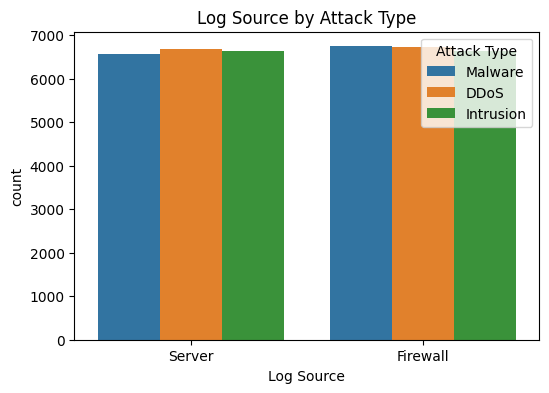

In [71]:
# visualization of Log Source by Attack Type

plt.figure(figsize=(6,4))
sns.countplot(data=df, x="Log Source", hue="Attack Type")
plt.title("Log Source by Attack Type")
plt.show()


### Interpretation

The Log Source feature contains no missing values and has very low cardinality, with only two distinct categories (Firewall and Server). This makes it a clean, simple categorical variable with no preprocessing issues related to sparsity or missing data.

The overall distribution is almost perfectly balanced, with Firewall (50.3%) and Server (49.7%) contributing nearly equal proportions of observations. This balance ensures uniform representation and avoids bias toward a particular log source.

When examined by Attack Type, the proportions remain remarkably stable across DDoS, Intrusion, and Malware. For each attack category, roughly half of the events originate from firewall logs and half from server logs, with differences well below 1%. The countplot visually confirms this uniformity, showing nearly identical bar heights across log sources and attack types.

Overall, Log Source does not exhibit discriminative power with respect to attack type. Instead, it functions as a contextual metadata feature, indicating where the event was logged rather than providing insight into the nature of the attack itself. While the feature is clean and reliable, its standalone predictive contribution is expected to be minimal.

## 2.18 Correlation Heatmap

In [72]:
num_cols = [
    "Source Port",
    "Destination Port",
    "Packet Length",
    "Anomaly Scores",
    "hour",
    "dayofweek",
    "month",
    "is_weekend",
    "payload_len"
]

num_df = df[num_cols]


In [73]:
corr_matrix = num_df.corr()

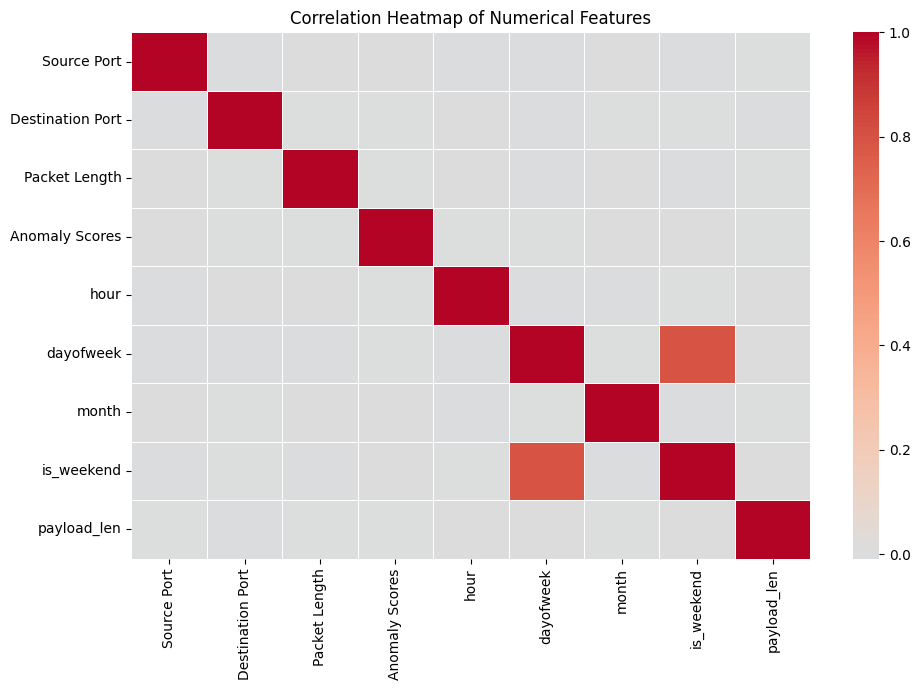

In [74]:
plt.figure(figsize=(10, 7))
sns.heatmap(
    corr_matrix,
    annot=False,
    cmap="coolwarm",
    center=0,
    linewidths=0.5
)

plt.title("Correlation Heatmap of Numerical Features")
plt.tight_layout()
plt.show()

### Interpretation

The correlation heatmap shows no strong linear relationships among most numerical features. Correlation values are close to zero for the majority of variable pairs, indicating low redundancy and limited linear dependency. The only noticeable correlation appears between dayofweek and is_weekend, which is expected since the weekend indicator is directly derived from the day of the week. Overall, this analysis suggests that predictive performance is more likely to rely on non-linear interactions between features rather than individual linear effects.

# **3. Feature Engineering and Selection**

## 3.1 Traffic Type,Protocol, Log Source, Network Segment, and Action Taken columns
Each have three possible values. Since there is no meaningful numerical order among the values, one-hot encoding has been applied.

In [75]:
df = pd.get_dummies(df, columns=["Traffic Type"], dtype=int)

In [76]:
df = pd.get_dummies(df, columns=["Protocol"], dtype=int)

In [77]:

df = pd.get_dummies(df,columns = ["Log Source"], dtype = int)


In [78]:
df["Log Source_Firewall"]

,Log Source_Firewall
0,0
1,1
2,1
3,1
4,1
...,...
39995,1
39996,1
39997,0
39998,0


In [79]:
df = pd.get_dummies(df, columns= ["Network Segment"],dtype= int)
print (df.columns)

Index(['Timestamp', 'Source IP Address', 'Destination IP Address',
       'Source Port', 'Destination Port', 'Packet Length', 'Packet Type',
       'Payload Data', 'Malware Indicators', 'Anomaly Scores',
       'Alerts/Warnings', 'Attack Type', 'Attack Signature', 'Action Taken',
       'Severity Level', 'User Information', 'Device Information',
       'Geo-location Data', 'Proxy Information', 'Firewall Logs',
       'IDS/IPS Alerts', 'hour', 'dayofweek', 'month', 'is_weekend',
       'payload_len', 'Malware Indicators_present', 'Alerts/Warnings_present',
       'Firewall Logs_present', 'IDS/IPS Alerts_present', 'Traffic Type_DNS',
       'Traffic Type_FTP', 'Traffic Type_HTTP', 'Protocol_ICMP',
       'Protocol_TCP', 'Protocol_UDP', 'Log Source_Firewall',
       'Log Source_Server', 'Network Segment_Segment A',
       'Network Segment_Segment B', 'Network Segment_Segment C'],
      dtype='object')


In [80]:
df = pd.get_dummies(df, columns=["Action Taken"], dtype=int)

In [81]:
df["Action Taken_Logged"]

,Action Taken_Logged
0,1
1,0
2,0
3,0
4,0
...,...
39995,1
39996,1
39997,0
39998,0


## 3.2 IDS/IPS alerts, Firewall logs, Malware Indicators Proxy information and Alerts/Warnings columns
They contain unique values, and the absence of a value indicates either that the software was not used or that no security detection occurred. Therefore, these columns can be simplified and represented as boolean features.

In [82]:
df["IDS/IPS Alerts"] = df["IDS/IPS Alerts"].notna().astype(int)
df["IDS/IPS Alerts"]

,IDS/IPS Alerts
0,0
1,0
2,1
3,1
4,1
...,...
39995,1
39996,0
39997,1
39998,0


In [83]:
df["Malware Indicators"] = df["Malware Indicators"].notna().astype(int)
df["Malware Indicators"]


,Malware Indicators
0,1
1,1
2,1
3,0
4,0
...,...
39995,1
39996,1
39997,1
39998,1


In [84]:
df["Firewall Logs"] = df["Firewall Logs"].notna().astype(int)
df["Firewall Logs"]

,Firewall Logs
0,1
1,1
2,1
3,0
4,0
...,...
39995,1
39996,1
39997,1
39998,1


In [85]:
df["Proxy Information"] = df["Proxy Information"].notna().astype(int)
df["Proxy Information"]


,Proxy Information
0,1
1,0
2,1
3,0
4,1
...,...
39995,0
39996,1
39997,0
39998,1


In [86]:
df["Alerts/Warnings"] = df["Alerts/Warnings"].notna().astype(int)

## 3.3 Severity Level column
It can be replaced with integer values, as there is an inherent order between the levels: low < medium < high

In [87]:
df["Severity Level"] = df["Severity Level"].replace(
    {'Low' : 1,
     'Medium' : 2,
     'High' : 3,
    }
)

/tmp/ipython-input-559/1833464578.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Severity Level"] = df["Severity Level"].replace(


## 3.4 Anomaly Scores and Packet Length columns
Min-Max scaling was applied to reduce the range of values.

In [88]:
print(min(df['Anomaly Scores']))
print(max(df['Anomaly Scores']))
# It would have been possible to scale simply by dividing by 100, but using MinMaxScaler was preferred for general purposes.

0.0
100.0


In [89]:
scaler = MinMaxScaler()
df["Anomaly Scores_Scaled"] = scaler.fit_transform(df[["Anomaly Scores"]])
df = df.drop(columns=["Anomaly Scores"])
df["Anomaly Scores_Scaled"]

,Anomaly Scores_Scaled
0,0.2867
1,0.5150
2,0.8742
3,0.1579
4,0.0052
...,...
39995,0.3928
39996,0.2725
39997,0.3101
39998,0.9785


In [90]:
df["Packet_Length_Scaled"] = scaler.fit_transform(df[["Packet Length"]])
df = df.drop(columns=["Packet Length"])
df["Packet_Length_Scaled"]

,Packet_Length_Scaled
0,0.305710
1,0.772981
2,0.168524
3,0.223538
4,0.973538
...,...
39995,0.949861
39996,0.779944
39997,0.681755
39998,0.291783


## 3.5 Attack Signature and Packet Type Columns
As Packet Type and Attack Signature are a two unique values columns with no meaningful numerical order, we can replace them with boolean values.

In [91]:
df["Attack Signature"] = df["Attack Signature"].replace(
    {
        'Known Pattern A' : 0,
        'Known Pattern B' : 1,
    }
)

/tmp/ipython-input-559/2631482167.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Attack Signature"] = df["Attack Signature"].replace(


In [92]:
df["Packet Type"] = df["Packet Type"].replace(
      {
        'Data': 0,
        'Control': 1,
      }
)

/tmp/ipython-input-559/1011122299.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Packet Type"] = df["Packet Type"].replace(


## 3.6 Destination Port Column and Source Port Column
The ports can be categorized into three groups: those less than 1023, considered system ports; those between 1024 and 49151, called registered ports; and those between 49152 and 65535, called ephemeral ports. However, in this dataset, no system ports are present, so this category will be dropped from the created column.However **If new cyberattack cases include system ports, this column will need to be handled differently** (for instance via one-hot encoding).

In [93]:
print((df["Destination Port"] <= 1023).sum())
print((df["Source Port"] <= 1023).sum())

0
0


In [94]:

df["Destination_Port_Category"] = (df["Destination Port"] <= 49151).astype(int) #Split into two category, those higher and lesser than 49 151
df["Source_Port_Category"] = (df["Source Port"] <= 49151).astype(int)

df = df.drop(columns = ["Destination Port"])      #The column is dropped, as the raw data may introduce noise for the model.
df = df.drop(columns = ["Source Port"])

df["Source_Port_Category"].head(20)





,Source_Port_Category
0,1
1,1
2,1
3,1
4,1
5,1
6,1
7,1
8,0
9,1


## 3.7 Timestamp column
The timestamp is split into Year, Month, Day of Week, and Hour. Minutes and seconds are dropped, as this information is negligible.

In [95]:
df["Timestamp"] = pd.to_datetime(df["Timestamp"],format="%Y-%m-%d %H:%M:%S")
df["Timestamp"][0].second
# Make sure this columns gives the proper data


58

In [96]:
df["year"] = df["Timestamp"].dt.year-2020
df["month"] = df["Timestamp"].dt.month
df["dayofweek"] = df["Timestamp"].dt.dayofweek   # 0 = lundi
df["hour"] = df["Timestamp"].dt.hour
df = df.drop(columns=["Timestamp"])
#x["is_weekend"] = x["dayofweek"].isin([5, 6]).astype(int)


## 3.8 Device Information Column
The Device Information column contains multiple types of data, some of which seem irrelevant for detecting attack types.
It was decided to extract the operating system of the victim machine and create a cybersecurity-related feature based on the OS version, which can be adjusted if "out-of-bound" operating systems appear, such as Windows, which has multiple versions.
OS will be kept as a string, but we will use a model that can handle categorical features directly (e.g., LightGBM, CatBoost), or use a label encoder to assign numeric codes to the different operating systems without implying any order.

In [97]:

# Extract the second word from the Device Information string, removing "(" and ";" for consistency

print(df["Device Information"][39996].split()[1].replace("(", "").replace(";", ""))
print(df["Device Information"][1].split()[1].replace("(", "").replace(";", ""))
# Condition to identify Windows PC: value could be "Windows" or "compatible"


print(df["Device Information"][3].split()[1].replace("(", "").replace(";", ""))
# Condition to identify Mac: value is "Macintosh"

print(df["Device Information"][5].split()[1])
# Condition to identify Linux: value is "Linux"

# Example 4: Check if the device is an iPod
print(df["Device Information"][10].split()[1].replace("(", "").replace(";", ""))

# Example 5: Check if the device is an iPhone
print(df["Device Information"][19].split()[1].replace("(", "").replace(";", ""))

# Observation: Different syntaxes exist in the data. Handling all cases manually would be impractical.


Windows
compatible
Macintosh
Linux
iPod
iPhone


In [98]:

df["Device Information"].str.split().str[1].str.replace(r"[();]", "", regex=True).unique()

#13 unique values

array(['compatible', 'Macintosh', 'Linux', 'Windows', 'iPod', 'NT', 'X11',
       'iPhone', 'iPad', 'Android', '95', 'CE', '98'], dtype=object)

In [99]:
clean = df["Device Information"].str.replace(r"((Mozilla/[^ ]+ )|(Opera[^.]+.[^.]+.)|[();])", " ", regex=True).str.strip()
print(clean.str.split().str[0].unique())

# We now have 9 unique values. However, we know that "X11" is associated with Linux.


['compatible' 'Macintosh' 'X11' 'Windows' 'iPod' 'iPhone' 'iPad' 'Android'
 'Linux']


In [100]:
# Total number of rows containing "compatible"
total_compatible = df["Device Information"].str.contains("compatible").sum()

# Rows containing both "compatible" **and** "Windows"
total_compatible_windows = (df["Device Information"].str.contains("compatible") & df["Device Information"].str.contains("Windows")).sum()

print(total_compatible, total_compatible_windows)

# The number of rows containing "compatible" is equal to the number of rows containing both "compatible" and "Windows".
# Conclusion: "compatible" corresponds to the Windows operating system.



7995 7995


In [101]:
# Functions to return a tuple containing the OS and its version

# To call if the entry starts with "compatible" or "Windows"
def WinColumnTransform(splitColumn: str) -> tuple:
    listOfString = splitColumn.split()
    for i, l in enumerate(listOfString):
        if "NT" in l:
            try:
                version = float(listOfString[i+1])
            except:
                pass

    for i, l in enumerate(listOfString):
        if "95" in l:
            version = float(1.0)  # Based on research, a distinction is made between NT and non-NT Windows OS. The version value was chosen arbitrarily.
            break
        elif "98" in l:
            version = float(2.0)
            break
        elif "CE" in l:
            version = float(0.0)
            break
    if version is None:
        raise ValueError(f"Version not found with index {i} value {l}")

    return tuple(("Windows", float(version)))

print("for compatible entry found:", WinColumnTransform(clean[0]))
print("for Windows entry found:", WinColumnTransform(clean[16]))
print("for Windows entry with different syntax found:", WinColumnTransform(clean[9]))

# To call if the entry starts with "X11": returns 1.0 because Linux OS does not have version information
def LinuxColumnTransform(splitColumn: str) -> float:
    return tuple(("Linux", 1.0))

print(LinuxColumnTransform(clean[42]))

# To call if the entry starts with "Linux" or "Android": returns Android and its version
# Special case: Android is based on Linux, so finding Linux in this area means that the device is an android
def AndroidColumnTransform(splitColumn: str) -> tuple:
    if splitColumn.split()[0] == "Linux":
        version = float(splitColumn.split()[2][0:3])
    else:
        version = float(splitColumn.split()[1][0:3])
    return tuple(("Android", version))

print("for Linux entry found:", AndroidColumnTransform(clean[42]))
print("for Android entry found:", AndroidColumnTransform(clean[67]))

# To call if the entry starts with "Macintosh"
def MacintoshColumnTransform(splitColumn: str) -> tuple:
    version_raw = splitColumn.split()[5].replace("_", " ").split()
    if len(version_raw) < 2:
        version_raw = splitColumn.split()[6].replace("_", " ").split()
    version = float(version_raw[0] + "." + version_raw[1])
    return tuple(("Macintosh", version))

print(MacintoshColumnTransform(clean[7]))

# To call if the entry starts with "iPod"
def iPodTransform(splitColumn: str) -> tuple:
    version_raw = splitColumn.split()[5].replace("_", " ").split()
    version = float(version_raw[0] + "." + version_raw[1])
    return tuple(("iPod", version))

print(iPodTransform(clean[46]))

# To call if the entry starts with "iPad"
def iPadTransform(splitColumn: str) -> tuple:
    version_raw = splitColumn.split()[4].replace("_", " ").split()
    version = float(version_raw[0] + "." + version_raw[1])
    return tuple(("iPad", version))

print(iPadTransform(clean[61]))

# To call if the entry starts with "iPhone"
def iPhoneTransform(splitColumn: str) -> tuple:
    version_raw = splitColumn.split()[4].replace("_", " ").split()
    version = float(version_raw[0] + "." + version_raw[1])
    return tuple(("iPhone", version))

print(iPhoneTransform(clean[68]))


for compatible entry found: ('Windows', 6.2)
for Windows entry found: ('Windows', 6.1)
for Windows entry with different syntax found: ('Windows', 6.0)
('Linux', 1.0)
for Linux entry found: ('Android', 4.4)
for Android entry found: ('Android', 6.0)
('Macintosh', 10.7)
('iPod', 3.3)
('iPad', 7.1)
('iPhone', 4.2)


In [102]:
# @title
def OsWithVersion(idx_val):
    index, val = idx_val
    try:
        match val.split()[0]:
            case "Windows" | "compatible":
                return WinColumnTransform(val)
            case "X11":
                return LinuxColumnTransform(val)
            # Special case: if we return Linux here, it actually refers to Android, which is based on Linux
            case "Linux" | "Android":
                return AndroidColumnTransform(val)
            case "Macintosh":
                return MacintoshColumnTransform(val)
            case "iPod":
                return iPodTransform(val)
            case "iPad":
                return iPadTransform(val)
            case "iPhone":
                return iPhoneTransform(val)
            case _:
                # Raise an error if the OS is unrecognized
                raise ValueError(f"Unrecognized OS: {val} at index {index}")
    except Exception as e:
        # If any error occurs during the match or in the sub-functions
        raise ValueError(f"Error at index {index} with value: {val}") from e


In [103]:
# @title
osInformation = []
for idx, val in clean.items():
    try:
        osInformation.append(OsWithVersion((idx, val)))
    except ValueError as e:
        raise e
tmp = pd.DataFrame(osInformation, columns=["OS_name", "Os_Version_Security"])


print(tmp.isna().sum()) # no null values

print(tmp.head(30))


OS_name                0
Os_Version_Security    0
dtype: int64
      OS_name  Os_Version_Security
0     Windows                 6.20
1     Windows                 6.00
2     Windows                 6.20
3   Macintosh                10.11
4     Windows                 6.20
5       Linux                 1.00
6       Linux                 1.00
7   Macintosh                10.70
8   Macintosh                10.50
9     Windows                 6.00
10       iPod                 4.30
11      Linux                 1.00
12    Windows                 6.00
13    Windows                10.00
14      Linux                 1.00
15      Linux                 1.00
16    Windows                 6.10
17      Linux                 1.00
18    Windows                10.00
19     iPhone                12.40
20  Macintosh                10.11
21    Windows                 5.01
22    Windows                 1.00
23    Windows                 5.00
24    Windows                 5.10
25    Windows              

In [104]:
df[["OS_name","Os_Version_Security"]] = tmp[["OS_name","Os_Version_Security"]]
df = df.drop(columns=["Device Information"])
df[["OS_name","Os_Version_Security"]]

,OS_name,Os_Version_Security
0,Windows,6.20
1,Windows,6.00
2,Windows,6.20
3,Macintosh,10.11
4,Windows,6.20
...,...,...
39995,iPad,14.20
39996,Windows,2.00
39997,Windows,4.00
39998,Linux,1.00


In [105]:
df.loc[df["OS_name"] == "Windows", ["OS_name", "Os_Version_Security", "Attack Type"]] \
 .groupby(["OS_name", "Os_Version_Security", "Attack Type"]) \
 .size()


OS_name  Os_Version_Security  Attack Type
Windows  0.00                 DDoS           479
                              Intrusion      462
                              Malware        458
         1.00                 DDoS           491
                              Intrusion      470
                              Malware        469
         2.00                 DDoS           931
                              Intrusion      917
                              Malware        937
         4.00                 DDoS           448
                              Intrusion      518
                              Malware        449
         5.00                 DDoS           431
                              Intrusion      449
                              Malware        477
         5.01                 DDoS           442
                              Intrusion      436
                              Malware        448
         5.10                 DDoS           440
                              Intrusion      443
                              Malware        486
         5.20                 DDoS           475
                              Intrusion      432
                              Malware        478
         6.00                 DDoS           449
                              Intrusion      457
                              Malware        455
         6.10                 DDoS           513
                              Intrusion      416
                              Malware        454
         6.20                 DDoS           480
                              Intrusion      441
                              Malware        467
         10.00                DDoS           435
                              Intrusion      465
                              Malware        455
dtype: int64

## 3.9 User Information and Payload Data columns
No useful informations can be extracted from this column to help the model predict the attack type. Therefore, this columns are dropped

In [106]:
df = df.drop(columns=["User Information"])

In [107]:
df = df.drop(columns=["Payload Data"])

## 3.10 Destination IP Address and Source IP Address Column
Dropped as the raw data is not usable and the Country extracted from it would give high cardinality with no real information for the model

In [108]:
df = df.drop(columns = ['Destination IP Address'])
df = df.drop(columns = ['Source IP Address'])

## 3.11 Geo-location Data Column
Using a geo-locator to find longitude and latitude would take several hours. Moreover, we cannot know in advance whether this information will be relevant or if the values will even exist.
As the number of unique values is very high, it cannot be meaningfully categorized.
Therefore, this column will be dropped to avoid introducing noise.

In [109]:
print(df["Geo-location Data"].nunique())
print(df["Geo-location Data"].notna().sum())


8723
40000


In [110]:
'''geo_locator = Nominatim(user_agent="geo_app")
geo_limiter = RateLimiter(geo_locator.geocode, min_delay_seconds=1)'''
#Dropped


'geo_locator = Nominatim(user_agent="geo_app")\ngeo_limiter = RateLimiter(geo_locator.geocode, min_delay_seconds=1)'

In [111]:

df = df.drop(columns=["Geo-location Data"])


## 3.12 Attack Type Column
Since this column is the target we want to predict, one-hot encoding into three columns is not an option. The three unique values have been replaced with numeric codes, but the model will not perform any comparisons on them, because this column is the target.

In [112]:
df["Attack Type"] = df["Attack Type"].replace(
    {'Malware' : 0,
     'DDoS' : 1,
     'Intrusion' : 2,
    }
)

#df = pd.get_dummies(df, columns=["Attack Type"], dtype=int)




/tmp/ipython-input-559/3927158291.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Attack Type"] = df["Attack Type"].replace(


## 3.13 Export

In [113]:
df.to_csv('cybersecurity_attacks_cleaned.csv', index=False)

# **4. Model Selection, Comparison and Evaluation**

**Dataset:** `cybersecurity_attacks_cleaned.csv`  
**Target:** Classify network traffic as `DDoS`, `Intrusion`, or `Malware`  
**Models Evaluated:** Random Forest, XGBoost, Logistic Regression, Decision Tree, CatBoost  
**Evaluation Metric:** F1-Macro (equal weight across all 3 classes)

**Model Chosen:** Logistic Regression

## 4.1 Preprocessing

We perform the following preprocessing steps:
1. Rename columns to remove spaces (required for some models)
2. Reconstruct the target variable `Attack_Type` from one-hot encoded columns
3. Encode the target variable numerically using `LabelEncoder`
4. Drop irrelevant or leaking columns from features

In [114]:
# The original 'Attack Type' column was already encoded with integer values (0, 1, 2).
# This step is modified to directly use the existing 'Attack Type' column for the new 'Attack_Type' column.
y = df["Attack Type"]

In [115]:
le = LabelEncoder()
df["OS_name"] = le.fit_transform(df["OS_name"])

In [116]:
# Define feature matrix X by dropping:
# - Attack Type: the target variable we just created

X = df.drop(columns=['Attack Type'])



## 4.2 Train/Test Split

- **80% training** / **20% testing**
- `stratify=y` ensures each split has equal proportions of DDoS, Intrusion, and Malware

In [117]:
# Split dataset: stratify ensures balanced class distribution in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


## 4.3 Evaluation Function

A reusable function that takes any trained model and returns:  
`accuracy`, `f1`, `precision`, `recall` all using **macro averaging** to treat all 3 classes equally.

In [118]:
def evaluate(model, X_test, y_test):
    """
    Evaluates a trained classifier on the test set.

    Parameters:
        model   : trained sklearn-compatible model
        X_test  : test features
        y_test  : true labels (encoded)

    Returns:
        dict with accuracy, f1, precision, recall (all macro-averaged)
    """
    y_pred = model.predict(X_test)

    return {
        "accuracy"  : round(accuracy_score(y_test, y_pred), 4),
        "f1"        : round(f1_score(y_test, y_pred, average="macro"), 4),
        "precision" : round(precision_score(y_test, y_pred, average="macro"), 4),
        "recall"    : round(recall_score(y_test, y_pred, average="macro"), 4)
    }


## 4.4 Random Forest Model

**Random Forest** is a bagging ensemble of multiple Decision Trees.  
Each tree votes on the prediction and the majority class wins.  
GridSearchCV tunes hyperparameters using 5-fold cross-validation.

In [119]:
# Define the base Random Forest model
rf = RandomForestClassifier(random_state=42)
rf_params = {
    "n_estimators"    : [100, 200],
    "max_depth"       : [None, 10, 20],
    "min_samples_split": [2, 5]
}

rf_model = GridSearchCV(
    rf,
    rf_params,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

# Extract the best model found by GridSearchCV
best_rf = rf_model.best_estimator_
print("Random Forest trained")
print("Best Parameters:", rf_model.best_params_)

Random Forest trained
Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


In [120]:
# Evaluate Random Forest on the test set
rf_scores = evaluate(best_rf, X_test, y_test)
print("Random Forest Results:")
print(rf_scores)

Random Forest Results:
{'accuracy': 0.3426, 'f1': 0.3423, 'precision': 0.3425, 'recall': 0.3425}


In [121]:
# Test predictions on 10 sample rows
tst = X_test.iloc[:10]

# Predict class labels
predictions = best_rf.predict(tst)
predicted_labels = le.inverse_transform(predictions)
actual_labels    = le.inverse_transform(y_test[:10])

# Predict class probabilities (confidence per class)
probabilities = best_rf.predict_proba(tst)

# Display comparison
rf_comparison = pd.DataFrame({
    "Actual"             : actual_labels,
    "RF_Predicted"       : predicted_labels
})
print("Random ForestPredictions:")
print(rf_comparison)

Random ForestPredictions:
      Actual RF_Predicted
0      Linux      Android
1  Macintosh    Macintosh
2  Macintosh    Macintosh
3      Linux      Android
4      Linux      Android
5  Macintosh      Android
6      Linux    Macintosh
7    Android        Linux
8    Android    Macintosh
9  Macintosh        Linux



## 4.5 XGBoost Model

**XGBoost** is a boosting ensemble models are trained sequentially,  
each correcting the errors of the previous one.  
It is widely considered state of the art for tabular classification tasks.

>  **Note:** XGBoost requires numerically encoded labels (0, 1, 2)  already handled by `LabelEncoder`.

In [122]:
# XGBoost requires its own label encoding (separate from RF/DT/LogReg)
le_xgb = LabelEncoder()
y_train_xgb = le_xgb.fit_transform(y_train)
y_test_xgb  = le_xgb.transform(y_test)

# Define base XGBoost model
xgb = XGBClassifier(
    random_state=42,
    eval_metric='logloss'   # logloss is standard for multiclass
)

xgb_params = {
    "n_estimators" : [100, 200],
    "max_depth"    : [3, 6],
    "learning_rate": [0.05, 0.1],
    "subsample"    : [0.8, 1.0]
}

xgb_model = GridSearchCV(
    xgb,
    xgb_params,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)

xgb_model.fit(X_train, y_train_xgb)

best_xgb = xgb_model.best_estimator_
print("XGBoost trained")
print("Best Parameters:", xgb_model.best_params_)

XGBoost trained
Best Parameters: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 100, 'subsample': 1.0}


In [123]:
# Evaluate XGBoost on the test set
xgb_scores = evaluate(best_xgb, X_test, y_test_xgb)
print("XGBoost Results:")
print(xgb_scores)

XGBoost Results:
{'accuracy': 0.334, 'f1': 0.3338, 'precision': 0.334, 'recall': 0.3339}


In [124]:
# Test predictions on 10 sample rows
xgb_tst = X_test.iloc[:10]

# Predict and decode back to original class names
pred_encoded    = best_xgb.predict(xgb_tst)
pred_labels_xgb = le_xgb.inverse_transform(pred_encoded)
actual_xgb      = le_xgb.inverse_transform(y_test_xgb[:10])

xgb_comparison = pd.DataFrame({
    "Actual"        : actual_xgb,
    "XGB_Predicted" : pred_labels_xgb
})
print("XGBoost Predictions:")
print(xgb_comparison)

XGBoost Predictions:
   Actual  XGB_Predicted
0       1              1
1       2              2
2       2              2
3       1              1
4       1              1
5       2              0
6       1              2
7       0              1
8       0              0
9       2              1



## 4.6 Decision Tree Model

**Decision Tree** is a single interpretable tree that splits data based on  
feature thresholds. It is the simplest model and the building block of  
Random Forest. It is prone to overfitting without depth constraints.

In [125]:
# Define base Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)

dt_params = {
    "max_depth"        : [None, 5, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf" : [1, 2, 4]
}
grid_dt = GridSearchCV(
    dt_model,
    dt_params,
    cv=3,
    scoring="f1_macro"
)

grid_dt.fit(X_train, y_train)

best_dt = grid_dt.best_estimator_
print("Decision Tree trained")
print("Best Parameters:", grid_dt.best_params_)

Decision Tree trained
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10}


In [126]:
# Evaluate Decision Tree on the test set
dt_scores = evaluate(best_dt, X_test, y_test)
print("Decision Tree Results:")
print(dt_scores)

Decision Tree Results:
{'accuracy': 0.3341, 'f1': 0.3337, 'precision': 0.3339, 'recall': 0.3341}


In [127]:
# Test predictions on 10 sample rows
samples_dt = X_test.iloc[:10]

pred_encoded_dt  = best_dt.predict(samples_dt)
pred_labels_dt   = le.inverse_transform(pred_encoded_dt)
actual_labels_dt = le.inverse_transform(y_test[:10])

dt_comparison = pd.DataFrame({
    "Actual"               : actual_labels_dt,
    "DecisionTree_Predicted": pred_labels_dt
})
print("Decision Tree Predictions:")
print(dt_comparison)

Decision Tree Predictions:
      Actual DecisionTree_Predicted
0      Linux                  Linux
1  Macintosh              Macintosh
2  Macintosh                  Linux
3      Linux                Android
4      Linux                  Linux
5  Macintosh              Macintosh
6      Linux                  Linux
7    Android                Android
8    Android                Android
9  Macintosh                  Linux



## 4.7 CatBoost Model

**CatBoost** is a gradient boosting library developed by Yandex.  
It uses ordered boosting to reduce overfitting and handles  
categorical features natively. It is a strong alternative to XGBoost.

In [128]:
# Define base CatBoost model
# verbose=0 suppresses training output during GridSearchCV
cat_model = CatBoostClassifier(
    random_state=42,
    verbose=0
)

cat_params = {
    "depth"        : [4, 6, 8],
    "learning_rate": [0.01, 0.05, 0.1],
    "iterations"   : [200, 500],
    "l2_leaf_reg"  : [1, 3, 5]
}

# GridSearchCV with 3-fold CV (CatBoost is slower to train)
# The first time with a 5-fold it took 20 minutes
grid_cat = GridSearchCV(
    cat_model,
    cat_params,
    cv=3,
    scoring="f1_macro",
    n_jobs=-1
)

grid_cat.fit(X_train, y_train)

best_cat = grid_cat.best_estimator_
print("CatBoost trained")
print("Best Parameters:", grid_cat.best_params_)

/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


CatBoost trained
Best Parameters: {'depth': 4, 'iterations': 200, 'l2_leaf_reg': 1, 'learning_rate': 0.05}


In [133]:
y_pred_cat = best_cat.predict(X_test)

print("CatBoost Detailed Report:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_cat):.4f}")
# Use list(label_map.values()) as target_names to match the 3 classes in y_test
print(classification_report(y_test, y_pred_cat, target_names=list(label_map.values())))

# Store scores using the evaluate function
cat_scores = evaluate(best_cat, X_test, y_test)
print("CatBoost Summary Scores:")
print(cat_scores)

CatBoost Detailed Report:
Accuracy: 0.3346
              precision    recall  f1-score   support

     Malware       0.34      0.33      0.34      2661
        DDoS       0.34      0.39      0.36      2686
   Intrusion       0.32      0.28      0.30      2653

    accuracy                           0.33      8000
   macro avg       0.33      0.33      0.33      8000
weighted avg       0.33      0.33      0.33      8000

CatBoost Summary Scores:
{'accuracy': 0.3346, 'f1': 0.3332, 'precision': 0.3338, 'recall': 0.3344}


In [134]:
# Test predictions on 10 sample rows
samples_cat = X_test.iloc[:10]

pred_encoded_cat  = best_cat.predict(samples_cat).astype(int)
pred_labels_cat   = le.inverse_transform(pred_encoded_cat)
actual_labels_cat = le.inverse_transform(y_test[:10])

cat_comparison = pd.DataFrame({
    "Actual"            : actual_labels_cat,
    "CatBoost_Predicted": pred_labels_cat,
    "Correct"           : actual_labels_cat == pred_labels_cat
})
print("CatBoost Predictions:")
print(cat_comparison)

CatBoost Predictions:
      Actual CatBoost_Predicted  Correct
0      Linux              Linux     True
1  Macintosh            Android    False
2  Macintosh              Linux    False
3      Linux            Android    False
4      Linux              Linux     True
5  Macintosh            Android    False
6      Linux          Macintosh    False
7    Android              Linux    False
8    Android            Android     True
9  Macintosh              Linux    False


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



## 4.8 Logistic Regression Model

**Logistic Regression** is a linear model that learns a decision boundary  
between classes. It is fast, interpretable, and serves as a strong baseline.  
We use a `Pipeline` to scale features before fitting required for convergence.

Technically the best performing model based on results and the one chosen for the web application

In [130]:
# Pipeline: StandardScaler normalises features, then LogisticRegression fits on them
# This is best practice: scaling prevents features with large ranges from dominating
log_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=2000))
])

log_params = {
    "logreg__C"      : [0.01, 0.1, 1, 10],
    "logreg__penalty": ["l2"],
    "logreg__solver" : ["lbfgs"]
}

log_grid = GridSearchCV(
    log_pipeline,
    log_params,
    cv=5,
    scoring="f1_macro",
    n_jobs=-1
)

log_grid.fit(X_train, y_train)

best_logreg = log_grid.best_estimator_
print("Logistic Regression trained")
print("Best Parameters:", log_grid.best_params_)

Logistic Regression trained
Best Parameters: {'logreg__C': 1, 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs'}


In [131]:
# Evaluate Logistic Regression on the test set
logreg_scores = evaluate(best_logreg, X_test, y_test)
print("Logistic Regression Results:")
print(logreg_scores)

Logistic Regression Results:
{'accuracy': 0.3361, 'f1': 0.3356, 'precision': 0.3365, 'recall': 0.336}


In [132]:
# Logistic Regression : Actual vs Predicted (10 samples)

label_map = {0: "Malware", 1: "DDoS", 2: "Intrusion"}

samples_lr = X_test.iloc[:10]

# Predict
pred_lr = best_logreg.predict(samples_lr)

lr_comparison = pd.DataFrame({
    "Actual"           : y_test.iloc[:10].map(label_map),
    "LogReg_Predicted" : pd.Series(pred_lr).map(label_map).values
})

print(lr_comparison.to_string(index=False))

   Actual LogReg_Predicted
     DDoS             DDoS
Intrusion          Malware
Intrusion             DDoS
     DDoS          Malware
     DDoS             DDoS
Intrusion        Intrusion
     DDoS          Malware
  Malware             DDoS
  Malware          Malware
Intrusion             DDoS


## 4.9 Ensemble (Random Forest + XGBoost — Soft Voting)

In [136]:
print("MODEL 2: ENSEMBLE  (Random Forest + XGBoost  —  Soft Voting)")


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


le_xgb = LabelEncoder()
y_train_xgb = le_xgb.fit_transform(y_train)
y_test_xgb  = le_xgb.transform(y_test)

start = time.time()
rf_model = RandomForestClassifier(
    n_estimators=200, max_depth=20, min_samples_split=5,
    min_samples_leaf=2, max_features='sqrt',
    random_state=42, n_jobs=-1, class_weight='balanced'
)
rf_model.fit(X_train_scaled, y_train)
rf_time = time.time() - start
print(f"  RF trained in {rf_time:.2f}s")


xgb_start_time = time.time()
best_xgb = XGBClassifier(
    random_state=42,
    eval_metric='mlogloss',
    learning_rate=0.05,
    max_depth=6,
    n_estimators=100,
    subsample=1.0
)
best_xgb.fit(X_train_scaled, y_train_xgb)
xgb_train_time = time.time() - xgb_start_time
print(f"  XGBoost trained in {xgb_train_time:.2f}s")


y_pred_xgb = best_xgb.predict(X_test_scaled)
xgb_accuracy  = accuracy_score(y_test_xgb, y_pred_xgb)
xgb_precision = precision_score(y_test_xgb, y_pred_xgb, average='weighted', zero_division=0)
xgb_recall    = recall_score(y_test_xgb, y_pred_xgb, average='weighted', zero_division=0)
xgb_f1        = f1_score(y_test_xgb, y_pred_xgb, average='weighted', zero_division=0)


start = time.time()
ensemble_model = VotingClassifier(
    estimators=[('rf', rf_model), ('xgb', best_xgb)],
    voting='soft', n_jobs=-1
)
ensemble_model.fit(X_train_scaled, y_train)
ens_train_time = time.time() - start

y_pred_ens_train = ensemble_model.predict(X_train_scaled)
y_pred_ens       = ensemble_model.predict(X_test_scaled)
y_proba_ens      = ensemble_model.predict_proba(X_test_scaled)

ens_accuracy  = accuracy_score(y_test, y_pred_ens)
ens_precision = precision_score(y_test, y_pred_ens, average='weighted', zero_division=0)
ens_recall    = recall_score(y_test, y_pred_ens, average='weighted', zero_division=0)
ens_f1        = f1_score(y_test, y_pred_ens, average='weighted', zero_division=0)

print(f"\n✓ Ensemble trained in {ens_train_time:.2f}s")
print(f"  Train Accuracy : {accuracy_score(y_train, y_pred_ens_train):.4f}  |  "
      f"Train F1 : {f1_score(y_train, y_pred_ens_train, average='weighted'):.4f}")
print(f"  Test  Accuracy : {ens_accuracy:.4f}  |  Test  F1 : {ens_f1:.4f}")
print(f"  Precision      : {ens_precision:.4f}  |  Recall   : {ens_recall:.4f}")




MODEL 2: ENSEMBLE  (Random Forest + XGBoost  —  Soft Voting)
  RF trained in 23.27s
  XGBoost trained in 3.63s

✓ Ensemble trained in 18.01s
  Train Accuracy : 1.0000  |  Train F1 : 1.0000
  Test  Accuracy : 0.3359  |  Test  F1 : 0.3357
  Precision      : 0.3358  |  Recall   : 0.3359


## 4.10 Model Comparison


Test Set Performance:
              Model  Accuracy  Precision   Recall  F1-Score  Train Time (s)
            XGBoost  0.334000   0.334025 0.334000  0.333810            3.63
Ensemble (RF + XGB)  0.335875   0.335757 0.335875  0.335705           18.01

Difference (Ensemble − XGBoost):
  Accuracy    : ▲ +0.1875%
  Precision   : ▲ +0.1733%
  Recall      : ▲ +0.1875%
  F1-Score    : ▲ +0.1895%


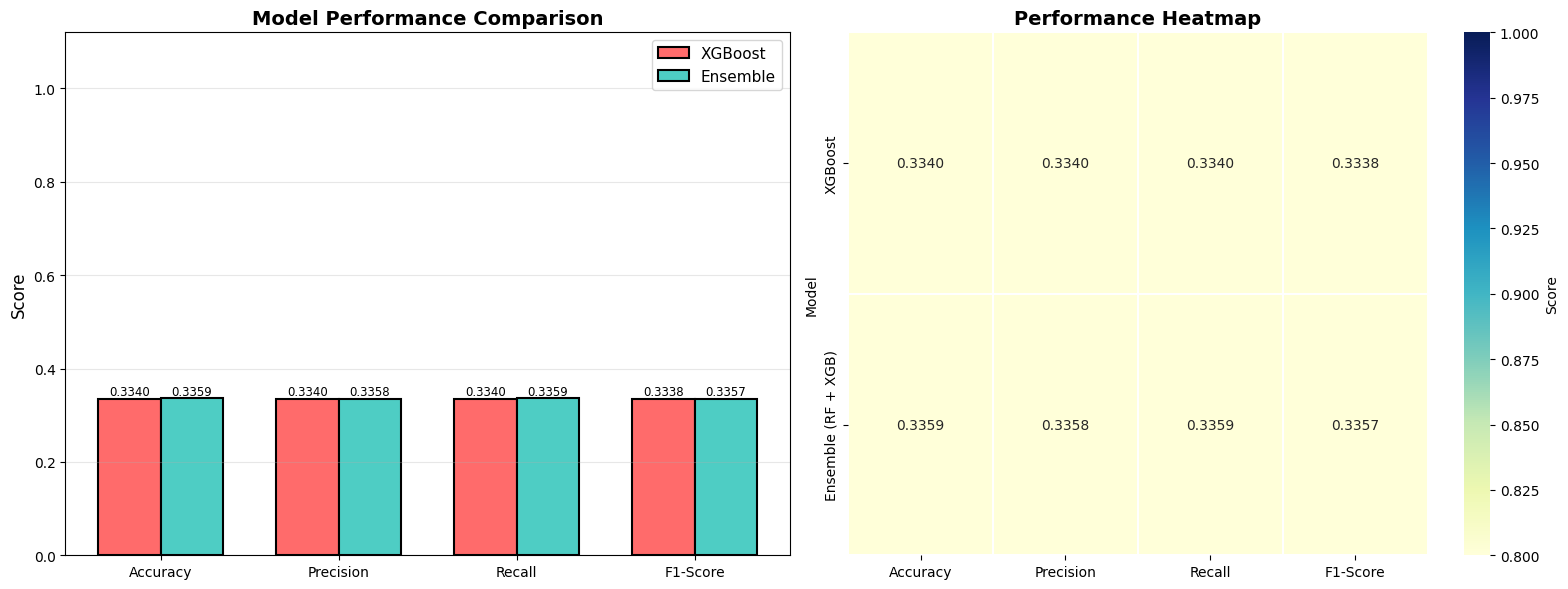

In [137]:
comparison_df = pd.DataFrame({
    'Model'         : ['XGBoost', 'Ensemble (RF + XGB)'],
    'Accuracy'      : [xgb_accuracy,   ens_accuracy],
    'Precision'     : [xgb_precision,  ens_precision],
    'Recall'        : [xgb_recall,     ens_recall],
    'F1-Score'      : [xgb_f1,         ens_f1],
    'Train Time (s)': [round(xgb_train_time, 2), round(ens_train_time, 2)]
})

print("\nTest Set Performance:")
print(comparison_df.to_string(index=False))

print("\nDifference (Ensemble − XGBoost):")
for m in ['Accuracy', 'Precision', 'Recall', 'F1-Score']:
    diff = (comparison_df.loc[1, m] - comparison_df.loc[0, m]) * 100
    symbol = '▲' if diff > 0 else ('▼' if diff < 0 else '=')
    print(f"  {m:12s}: {symbol} {diff:+.4f}%")

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

x = np.arange(len(metrics)); w = 0.35
b1 = axes[0].bar(x - w/2, comparison_df.iloc[0, 1:5], w,
                 label='XGBoost', color='#FF6B6B', edgecolor='black', lw=1.5)
b2 = axes[0].bar(x + w/2, comparison_df.iloc[1, 1:5], w,
                 label='Ensemble', color='#4ECDC4', edgecolor='black', lw=1.5)
axes[0].set_xticks(x); axes[0].set_xticklabels(metrics)
axes[0].set_ylim([0, 1.12]); axes[0].grid(axis='y', alpha=0.3)
axes[0].legend(fontsize=11)
axes[0].set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Score', fontsize=12)
for bars in [b1, b2]:
    for bar in bars:
        h = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., h + 0.002,
                     f'{h:.4f}', ha='center', va='bottom', fontsize=8.5)

pivot = comparison_df.set_index('Model')[metrics]
sns.heatmap(pivot, annot=True, fmt='.4f', cmap='YlGnBu',
            ax=axes[1], linewidths=1.2, linecolor='white',
            cbar_kws={'label': 'Score'}, vmin=0.8, vmax=1.0)
axes[1].set_title('Performance Heatmap', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
comparison_df.to_csv('model_comparison.csv', index=False)



## 4.11 Deep Analysis
### Confusion Matrices

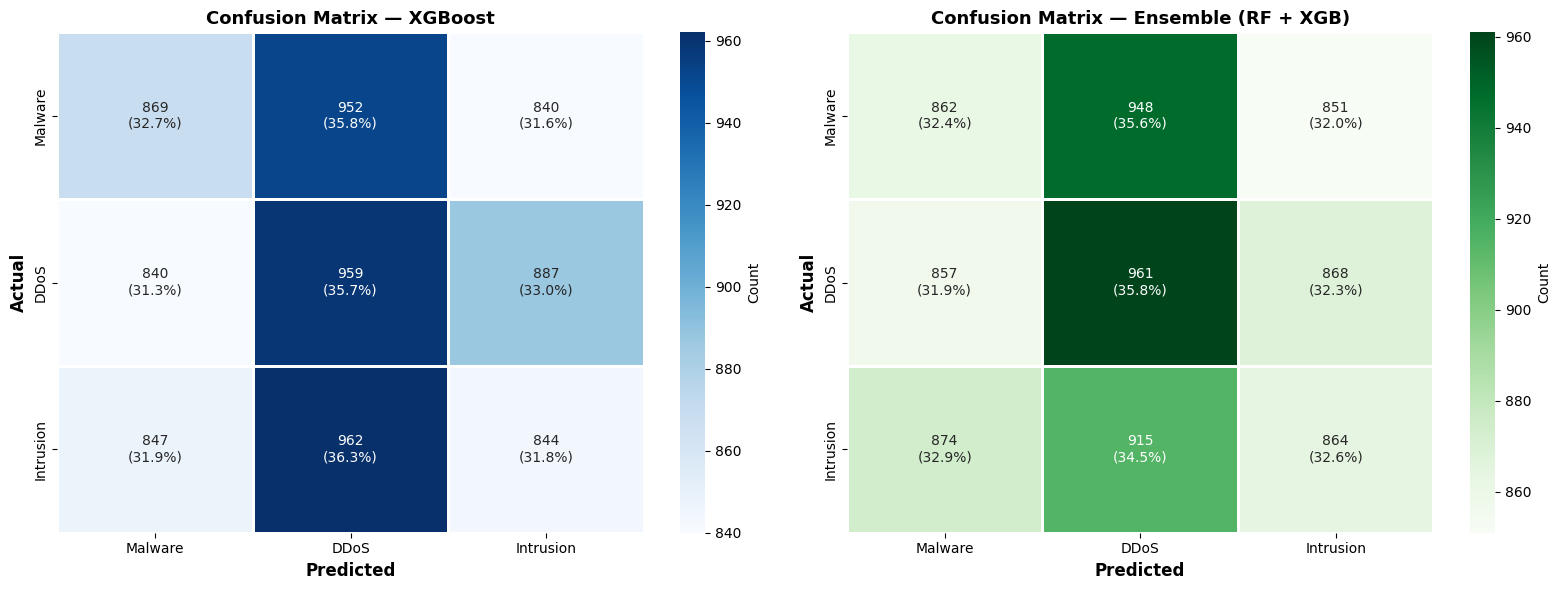


XGBoost per-class accuracy:
  Malware     : 0.3266
  DDoS        : 0.3570
  Intrusion   : 0.3181

Ensemble per-class accuracy:
  Malware     : 0.3239
  DDoS        : 0.3578
  Intrusion   : 0.3257


In [141]:

class_labels = list(label_map.values())

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
for ax, (y_pred, title, cmap) in zip(
    axes,
    [(y_pred_xgb, 'XGBoost', 'Blues'),
     (y_pred_ens, 'Ensemble (RF + XGB)', 'Greens')]
):
    cm = confusion_matrix(y_test, y_pred)
    cm_pct = cm.astype(float) / cm.sum(axis=1, keepdims=True) * 100
    annot = np.array([[f"{v}\n({cm_pct[i,j]:.1f}%)"
                       for j, v in enumerate(row)]
                      for i, row in enumerate(cm)])
    sns.heatmap(cm, annot=annot, fmt='', cmap=cmap, ax=ax,
                xticklabels=class_labels, yticklabels=class_labels,
                linewidths=1, linecolor='white', cbar_kws={'label': 'Count'})
    ax.set_xlabel('Predicted', fontsize=12, fontweight='bold')
    ax.set_ylabel('Actual',    fontsize=12, fontweight='bold')
    ax.set_title(f'Confusion Matrix — {title}', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()


for name, y_pred in [('XGBoost', y_pred_xgb), ('Ensemble', y_pred_ens)]:
    cm = confusion_matrix(y_test, y_pred)
    per_class_acc = cm.diagonal() / cm.sum(axis=1)
    print(f"\n{name} per-class accuracy:")
    for i, (cls, acc) in enumerate(zip(class_labels, per_class_acc)):
        print(f"  {cls:12s}: {acc:.4f}")

### Classification Reports


──────────────────────────────────────────────────  XGBoost  ──────────
              precision    recall  f1-score   support

     Malware     0.3400    0.3266    0.3331      2661
        DDoS     0.3338    0.3570    0.3450      2686
   Intrusion     0.3283    0.3181    0.3231      2653

    accuracy                         0.3340      8000
   macro avg     0.3340    0.3339    0.3338      8000
weighted avg     0.3340    0.3340    0.3338      8000


──────────────────────────────────────────────────  Ensemble  ──────────
              precision    recall  f1-score   support

     Malware     0.3324    0.3239    0.3281      2661
        DDoS     0.3403    0.3578    0.3488      2686
   Intrusion     0.3345    0.3257    0.3300      2653

    accuracy                         0.3359      8000
   macro avg     0.3357    0.3358    0.3357      8000
weighted avg     0.3358    0.3359    0.3357      8000



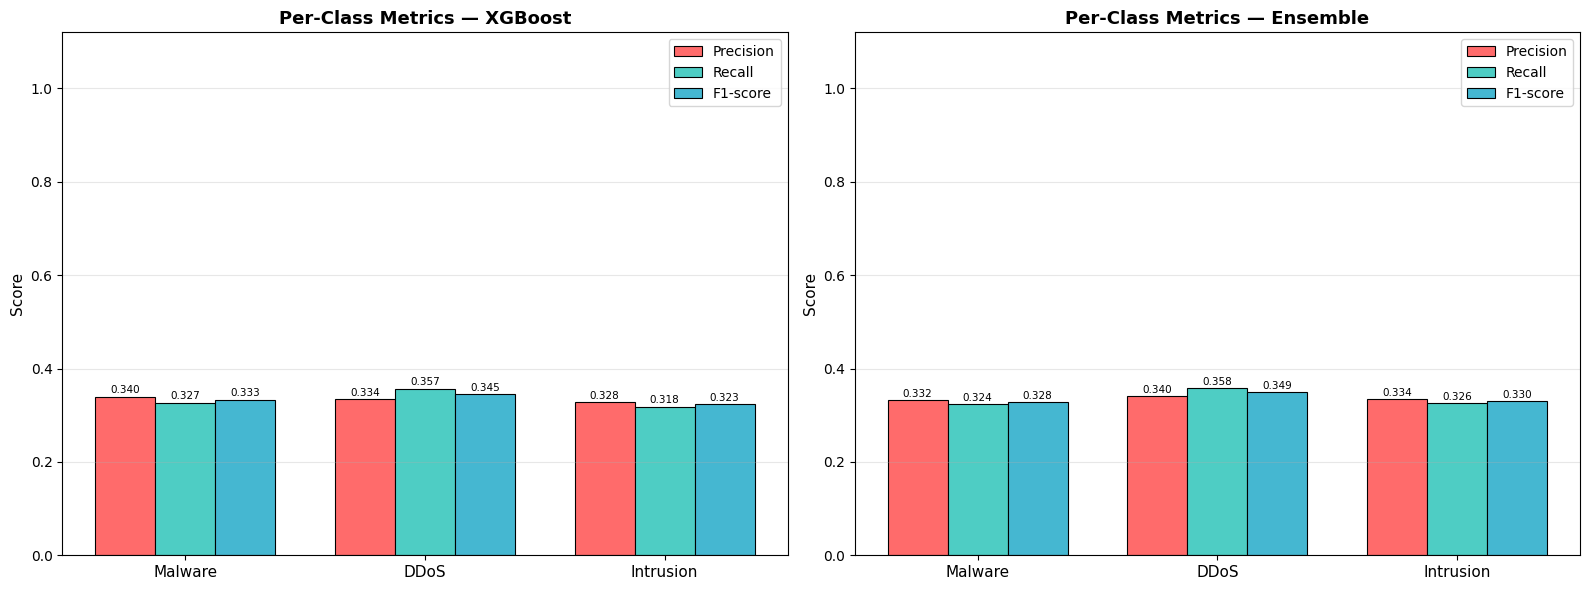

✓ Saved: classification_report_chart.png


In [142]:
for name, y_pred in [('XGBoost', y_pred_xgb), ('Ensemble', y_pred_ens)]:
    print(f"\n{'─'*50}  {name}  {'─'*10}")
    print(classification_report(y_test, y_pred, target_names=class_labels, digits=4))


fig, axes = plt.subplots(1, 2, figsize=(16, 6))
metric_keys = ['precision', 'recall', 'f1-score']
bar_colors  = ['#FF6B6B', '#4ECDC4', '#45B7D1']
x = np.arange(len(class_labels)); w = 0.25

for ax, (name, y_pred) in zip(axes, [('XGBoost', y_pred_xgb), ('Ensemble', y_pred_ens)]):
    report = classification_report(y_test, y_pred, target_names=class_labels, output_dict=True)
    for i, (mk, bc) in enumerate(zip(metric_keys, bar_colors)):
        vals = [report[cls][mk] for cls in class_labels]
        ax.bar(x + i*w, vals, w, label=mk.capitalize(),
               color=bc, edgecolor='black', lw=0.8)
    ax.set_xticks(x + w); ax.set_xticklabels(class_labels, fontsize=11)
    ax.set_ylim([0, 1.12]); ax.grid(axis='y', alpha=0.3)
    ax.legend(fontsize=10)
    ax.set_title(f'Per-Class Metrics — {name}', fontsize=13, fontweight='bold')
    ax.set_ylabel('Score', fontsize=11)
    for bars in ax.containers:
        ax.bar_label(bars, fmt='%.3f', fontsize=7.5, padding=1)

plt.tight_layout()
plt.savefig('classification_report_chart.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Saved: classification_report_chart.png")
